# 🧠 Deep Sector Rotation Swing Trading Notebook

This notebook implements a weekly ETF sector rotation strategy inspired by the paper:

**"Deep Sector Rotation Swing Trading"** (Bock & Maewal, SSRN #4280640)

---

### 📌 Strategy Summary:
- Trades once per week (Buy on Monday open, Sell on Friday close)
- Uses a deep learning model to predict next-week returns for selected ETFs
- Selects high-confidence trades using Monte Carlo Dropout
- Allocates capital selectively based on prediction strength

---

### 🔧 Key Components:
- Weekly ETF price data (e.g., XLK, XLF, XLV…)
- Rolling technical and macro features
- Multi-output regression model
- Weekly backtest with position logging and performance metrics


In [265]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# ETF list
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS'
]

# Date range
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(weeks=5*52)).strftime('%Y-%m-%d')

print(f"📅 Downloading data from {start_date} to {end_date}")

# Ensure dataset/ exists
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
if not os.path.isdir(dataset_path):
    raise FileNotFoundError(f"🚫 'dataset/' folder not found at {dataset_path}")

# Containers
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# Download each ETF
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date, interval='1wk', auto_adjust=False)
    if not data.empty:
        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# Merge and clean
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    path = os.path.join(dataset_path, filename)
    df.to_csv(path)
    print(f"✅ Saved: {filename}")
    return df

# Save all
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# Preview
price_df.head()


📅 Downloading data from 2020-04-20 to 2025-04-14
⬇️ Downloading XLK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⬇️ Downloading XLF...
⬇️ Downloading XLV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⬇️ Downloading XLE...
⬇️ Downloading XLI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

⬇️ Downloading XLY...
⬇️ Downloading XLP...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

⬇️ Downloading XLRE...
⬇️ Downloading XLU...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

⬇️ Downloading XLB...
⬇️ Downloading XLC...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

⬇️ Downloading SOXX...
⬇️ Downloading SH...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

⬇️ Downloading DOG...
⬇️ Downloading RWM...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

⬇️ Downloading ITA...
⬇️ Downloading JETS...



[*********************100%***********************]  1 of 1 completed

✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price             XLK        XLF        XLV        XLE        XLI         XLY  \
Ticker            XLK        XLF        XLV        XLE        XLI         XLY   
Date                                                                            
2020-04-20  84.995079  19.800920  92.707405  28.168423  56.930317  107.774208   
2020-04-27  85.253998  20.092381  90.433411  29.169207  57.577572  107.764626   
2020-05-04  90.892845  20.301867  91.893936  31.553192  58.354271  112.584435   
2020-05-11  89.636581  19.172468  92.827583  29.283115  54.979324  110.875404   
2020-05-18  92.532707  19.964867  92.088074  31.309093  59.029266  116.396156   

Price             XLP       XLRE        XLU        XLB        XLC       SOXX  \
Ticker            XLP       XLRE        XLU        XLB        XLC       SOXX   
Date                                                                           
2020-04-20  51.462593  27.985088  49.870865  45.131836  46.481487  73.612900   
2020-04-27  50.507133  27.815891  47.784367  45.973637  47.360302  71.331734   
2020-05-04  50.945415  28.213501  48.023808  47.503376  49.538231  76.902237   
2020-05-11  50.305534  26.208521  46.869381  46.046055  48.955536  73.753258   
2020-05-18  50.375660  27.663612  48.297447  47.910702  51.305405  78.060364   

Price              SH        DOG        RWM        ITA       JETS  
Ticker             SH        DOG        RWM        ITA       JETS  
Date                                                               
2020-04-20  94.152306  47.638866  39.331779  70.986542  13.265752  
2020-04-27  94.076530  47.620907  38.178116  71.822182  13.990603  
2020-05-04  90.818138  46.390881  36.040726  72.466789  13.543777  
2020-05-11  92.750450  47.549080  38.035030  67.185547  11.915346  
2020-05-18  89.681496  45.879120  35.083801  73.063698  13.603354

### 🌐 Weekly Macro Indicator Download

This section downloads weekly data for key macroeconomic signals that are used as input features for the model:

| Indicator        | Source Symbol | Description |
|------------------|---------------|-------------|
| **VIX**          | `^VIX`        | CBOE Volatility Index (market fear gauge) |
| **10Y Yield**    | `^TNX`        | 10-Year U.S. Treasury yield (interest rate proxy) |
| **USD Index**    | `DX-Y.NYB`    | Strength of the U.S. dollar |
| **Crude Oil**    | `CL=F`        | WTI Crude Oil futures price |

All indicators are:
- Downloaded at **weekly frequency** using Yahoo Finance
- Aligned on the same date index as the ETF data
- The 10-year yield is converted to a % by multiplying by `0.1`


In [266]:
import os
import yfinance as yf
import pandas as pd

# Macro indicator tickers on Yahoo Finance
macro_tickers = {
    'VIX': '^VIX',               # Volatility Index
    '10Y_Yield': '^TNX',         # 10-Year Treasury Yield (multiply by 0.1)
    'USD_Index': 'DX-Y.NYB',     # U.S. Dollar Index
    'WTI_Crude': 'CL=F'          # Crude Oil (WTI)
}

# Date range matching your ETF backtest period
start_date = (pd.Timestamp.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download weekly data
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False)
    macro_data[name] = data[['Close']].rename(columns={'Close': name})

# Combine all macro indicators into one DataFrame
macro_df = pd.concat(macro_data.values(), axis=1)

# Fix 10Y yield scale
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] = macro_df['10Y_Yield'] * 0.1

# Drop missing rows
macro_df.dropna(inplace=True)

# Save to CSV
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))
macro_df.to_csv(macro_save_path)
print(f"✅ Macro indicators saved to: {macro_save_path}")

# Preview

macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df.sort_index(inplace=True)
macro_df.head()



[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

✅ Macro indicators saved to: d:\CodingWorks\my_MLQT_project\Stock-Prediction-Models\dataset\macro_indicators_weekly.csv


Price             VIX 10Y_Yield   USD_Index  WTI_Crude
Ticker           ^VIX      ^TNX    DX-Y.NYB       CL=F
Date                                                  
2020-04-13  38.150002    0.0654   99.779999  18.270000
2020-04-20  35.930000    0.0596  100.379997  16.940001
2020-04-27  37.189999    0.0642   98.800003  19.780001
2020-05-04  27.980000    0.0682   99.730003  24.740000
2020-05-11  31.889999    0.0640  100.400002  29.430000

### 🧠 Feature Engineering

This section prepares input features for the machine learning model.

#### 📈 ETF-Specific Features:
For each ETF, we will compute:
- **1-week return**: Short-term price movement
- **3-week return**: Medium-term trend
- **6-week return**: Momentum across a longer window
- **Streak**: Number of consecutive up weeks

#### 🌐 Macro Indicators:
From the macro_df, we already have:
- **VIX**
- **10Y Treasury Yield**
- **USD Index**
- **Crude Oil Price**

These will be aligned with the ETF data by date and merged in.

#### 📦 Resulting Feature Matrix:
For each ETF on each week:
- One row = a snapshot of that ETF and macro environment
- Target = the **next week's return** for that ETF


In [267]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

# === Load datasets ===
price_df = pd.read_csv('../dataset/etf_prices_weekly.csv', index_col=0)
volume_df = pd.read_csv('../dataset/etf_volume_weekly.csv', index_col=0)
macro_df = pd.read_csv('../dataset/macro_indicators_weekly.csv', index_col=0)
high_df = pd.read_csv('../dataset/etf_high_weekly.csv', index_col=0)
low_df = pd.read_csv('../dataset/etf_low_weekly.csv', index_col=0)

# === Clean and convert ===
for df in [price_df, volume_df, macro_df, high_df, low_df]:
    df.index = pd.to_datetime(df.index, errors='coerce')
    df[:] = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=0, how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df.sort_index(inplace=True)
    df.dropna(inplace=True)

# === Feature generation ===
feature_rows = []

for symbol in price_df.columns:
    close = price_df[symbol]
    high = high_df[symbol]
    low = low_df[symbol]
    volume = pd.to_numeric(volume_df[symbol], errors='coerce').replace(0, np.nan)

    # Basic returns
    returns_1w = close.pct_change(1)
    returns_3w = close.pct_change(3)
    returns_6w = close.pct_change(6)
    streak = (close.pct_change(1) > 0).astype(int).rolling(3).sum()

    # Volume log norm
    log_volume = np.log(volume)
    log_volume_norm = log_volume / log_volume.rolling(5).mean()

    # Shock amplify
    shock_amplify_raw = (high - low) / close
    shock_amplify = shock_amplify_raw.rolling(3).mean()
    shock_amplify_1w = shock_amplify.shift(1)
    shock_amplify_3w = shock_amplify.rolling(3).mean()
    shock_delta = shock_amplify.diff()  # ✅ shock delta

    vol_flag = (
        shock_amplify_raw > (shock_amplify_raw.rolling(10).mean() +
                             2 * shock_amplify_raw.rolling(10).std())
    ).astype(int)

    # K/D
    rsv = (close - low.rolling(9).min()) / (high.rolling(9).max() - low.rolling(9).min()) * 100
    k = rsv.ewm(com=2).mean()
    d = k.ewm(com=2).mean()

    kd_signal = pd.Series(0, index=close.index)
    kd_signal[(k < 30) & (d < 30)] = 1
    kd_signal[(k > 70) & (d > 70)] = -1

    # ✅ MACD Slope
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    macd = ema12 - ema26
    macd_slope = macd.diff()

    # ✅ Momentum 2-week return
    momentum_2w = close.pct_change(2)

    # ✅ Interaction terms
    kd_x_shock = kd_signal * shock_amplify_3w
    streak_x_ret6 = streak * returns_6w

    for i in range(26, len(close) - 1):  # start at 26 to avoid NaNs
        date = close.index[i]
        try:
            nearest_macro_index = macro_df.index.get_indexer([date], method='nearest')[0]
            macro_row = macro_df.iloc[nearest_macro_index]
        except Exception:
            continue

        row = {
            'Date': date,
            'ETF': symbol,
            'Return_1w': returns_1w.iloc[i],
            'Return_3w': returns_3w.iloc[i],
            'Return_6w': returns_6w.iloc[i],
            'Streak_Up': streak.iloc[i],
            'LogVolumeNorm': log_volume_norm.iloc[i],
            'Shock_Amplify': shock_amplify.iloc[i],
            'Shock_Amplify_1w': shock_amplify_1w.iloc[i],
            'Shock_Amplify_3w': shock_amplify_3w.iloc[i],
            'Shock_Delta': shock_delta.iloc[i],
            'Vol_Flag': vol_flag.iloc[i],
            'KD_Signal': kd_signal.iloc[i],
            'MACD': macd.iloc[i],
            'MACD_Slope': macd_slope.iloc[i],
            'ROC_5w': close.pct_change(5).iloc[i],
            'Momentum_2w': momentum_2w.iloc[i],
            'KD_Signal_x_Shock3w': kd_x_shock.iloc[i],
            'Streak_x_Return6w': streak_x_ret6.iloc[i],
            'Target_Next_Week_Return': close.pct_change(1).shift(-1).iloc[i],
            'Direction': (close.pct_change(1).shift(-1).iloc[i] > 0).astype(int),
        }

        for col in macro_df.columns:
            row[col] = macro_row[col]

        feature_rows.append(row)

# === Save features ===
feature_df = pd.DataFrame(feature_rows)
feature_df.dropna(inplace=True)
feature_df.to_csv('../dataset/etf_features.csv', index=False)
print("✅ Feature CSV saved.")


C:\Users\user\AppData\Local\Temp\ipykernel_46752\2449077494.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_46752\2449077494.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_46752\2449077494.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_46752\2449077494.py:15: UserWarning: Co

✅ Feature CSV saved.


### 📌 Deep Sector Rotation Strategy with Shock-Aware Early Exit

This strategy builds on the "Deep Sector Rotation" approach proposed in [SSRN-4280640](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4280640), with the following modifications:

---

#### 🧠 Core Model (MLP)

- A multi-layer perceptron (MLP) is trained to predict next-week returns for each ETF independently.
- Features include:
  - Past 1w, 3w, 6w returns
  - Volume (log normalized)
  - Macro indicators (VIX, 10Y yield, USD index, oil)
  - Streak up count (3-week up trend)
  - Shock Amplify features:
    - This week
    - 1-week lag
    - 3-week average

---

#### 🔁 Weekly Rotation Rule (baseline)

- Each week (e.g., Monday), predict returns for all ETFs using the MLP.
- Rank the ETFs by predicted return.
- Buy top-N (e.g., 3) ETFs.
- Hold for 1 week (unless overridden by shock rule below).

---

#### ⚡ Shock Amplify Early Exit Rule (custom addition)

- Each day (or evaluation step), check for ETFs in the portfolio with:
  - `Shock_Amplify_3w` > +10% or < -10%
- If triggered:
  - Sell that ETF immediately.
  - Immediately start a new turn (predict again, re-select top-N).

---

#### 💼 Goal

- Combine deep learning-based prediction with handcrafted rules for volatility control.
- Achieve more stable and responsive ETF swing trading performance.


In [268]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display
import copy

# === Load feature set ===
feature_df = pd.read_csv('../dataset/etf_features.csv')
feature_df['Date'] = pd.to_datetime(feature_df['Date'], errors='coerce')
etf_groups = feature_df.groupby('ETF')

# === Model setup ===
features = [
    'Return_1w', 'Return_3w', 'Return_6w', 'Streak_Up',
    'LogVolumeNorm', 'Shock_Amplify', 'Shock_Amplify_1w', 'Shock_Amplify_3w',
    'Shock_Delta', 'Vol_Flag', 'KD_Signal', 'MACD', 'MACD_Slope',
    'ROC_5w', 'Momentum_2w', 'KD_Signal_x_Shock3w', 'Streak_x_Return6w',
    'VIX', '10Y_Yield', 'USD_Index', 'WTI_Crude'
]
target = 'Target_Next_Week_Return'
target_cls = 'Direction'
epochs = 500
batch_size = 64
lr = 0.001
snapshot_every = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Model ===
class MLPDualOutput(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.reg_head = nn.Linear(32, 1)
        self.cls_head = nn.Linear(32, 1)

    def forward(self, x):
        shared = self.shared(x)
        return self.reg_head(shared), torch.sigmoid(self.cls_head(shared))

# === Containers ===
results = []
all_predictions = []
win_rate_history = {}
offset_history = {}
weight_snapshots = {}
performance_snapshots = {}

# === Per-ETF Training Loop ===
for etf, df in etf_groups:
    df = df.sort_values('Date').dropna().reset_index(drop=True)
    if len(df) < 30:
        continue

    split = int(len(df) * 0.8)
    train_df = df.iloc[:split]
    test_df = df.iloc[split:]

    X_train = train_df[features].values
    y_train_reg = train_df[target].values
    y_train_cls = train_df[target_cls].values
    X_test = test_df[features].values
    y_test_reg = test_df[target].values
    y_test_cls = test_df[target_cls].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_reg, dtype=torch.float32).view(-1, 1)
    y_train_cls_tensor = torch.tensor(y_train_cls, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_reg, dtype=torch.float32).view(-1, 1)
    y_test_cls_tensor = torch.tensor(y_test_cls, dtype=torch.float32).view(-1, 1)

    model = MLPDualOutput(input_dim=len(features)).to(device)
    reg_loss_fn = nn.MSELoss()
    cls_loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor, y_train_cls_tensor),
                        batch_size=batch_size, shuffle=True)

    win_rate_history[etf] = []
    offset_history[etf] = []
    weight_snapshots[etf] = []
    performance_snapshots[etf] = []

    # === Training ===
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y_reg, batch_y_cls in loader:
            batch_X, batch_y_reg, batch_y_cls = batch_X.to(device), batch_y_reg.to(device), batch_y_cls.to(device)
            optimizer.zero_grad()
            out_reg, out_cls = model(batch_X)
            loss = reg_loss_fn(out_reg, batch_y_reg) + cls_loss_fn(out_cls, batch_y_cls)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # === Snapshot ===
        if (epoch + 1) % snapshot_every == 0:
            model.eval()
            with torch.no_grad():
                out_reg_val, _ = model(X_test_tensor.to(device))
                pred_np = out_reg_val.cpu().numpy().flatten()
                win_rate = (np.sign(pred_np) == np.sign(y_test_reg)).mean()
                offset = np.mean(np.abs(pred_np - y_test_reg))

                win_rate_history[etf].append((epoch + 1, win_rate))
                offset_history[etf].append((epoch + 1, offset))
                weight_snapshots[etf].append(copy.deepcopy(model.state_dict()))
                performance_snapshots[etf].append({
                    "epoch": epoch + 1,
                    "offset": offset,
                    "win": win_rate
                })

            print(f"[{etf}] Epoch {epoch+1}/{epochs} | Loss: {epoch_loss / len(loader):.6f} | Win: {win_rate:.2%} | Offset: {offset:.5f}")

    # === Final Evaluation ===
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device))[0].cpu().numpy().flatten()
        y_cls_pred = (model(X_test_tensor.to(device))[1].cpu().numpy().flatten() > 0.5).astype(int)

    mae = np.mean(np.abs(y_test_reg - y_pred))
    mse = np.mean((y_test_reg - y_pred) ** 2)
    win_rate = np.mean(np.sign(y_pred) == np.sign(y_test_reg))
    acc = accuracy_score(y_test_cls, y_cls_pred)

    test_copy = test_df.copy()
    test_copy['Predicted'] = y_pred
    test_copy['Predicted_Direction'] = y_cls_pred
    test_copy['Correct_Direction'] = (y_cls_pred == y_test_cls)
    test_copy['ETF'] = etf
    all_predictions.append(test_copy)

    results.append({
        'ETF': etf,
        'MAE': mae,
        'MSE': mse,
        'Win_Rate': win_rate,
        'Direction_Acc': acc,
        'Samples': len(df)
    })

# === Merge & Show ===
test_df = pd.concat(all_predictions).reset_index(drop=True)
summary = pd.DataFrame(results).sort_values('MAE')
display(summary)


[DOG] Epoch 50/500 | Loss: 0.547200 | Win: 44.68% | Offset: 0.02346
[DOG] Epoch 100/500 | Loss: 0.333927 | Win: 46.81% | Offset: 0.02658
[DOG] Epoch 150/500 | Loss: 0.187690 | Win: 44.68% | Offset: 0.02499
[DOG] Epoch 200/500 | Loss: 0.091026 | Win: 42.55% | Offset: 0.02571
[DOG] Epoch 250/500 | Loss: 0.042860 | Win: 44.68% | Offset: 0.02335
[DOG] Epoch 300/500 | Loss: 0.022063 | Win: 46.81% | Offset: 0.02151
[DOG] Epoch 350/500 | Loss: 0.012811 | Win: 44.68% | Offset: 0.02062
[DOG] Epoch 400/500 | Loss: 0.008261 | Win: 48.94% | Offset: 0.02093
[DOG] Epoch 450/500 | Loss: 0.005663 | Win: 48.94% | Offset: 0.02087
[DOG] Epoch 500/500 | Loss: 0.004094 | Win: 44.68% | Offset: 0.02165
[ITA] Epoch 50/500 | Loss: 0.587463 | Win: 51.06% | Offset: 0.03324
[ITA] Epoch 100/500 | Loss: 0.259158 | Win: 53.19% | Offset: 0.03665
[ITA] Epoch 150/500 | Loss: 0.080640 | Win: 57.45% | Offset: 0.03467
[ITA] Epoch 200/500 | Loss: 0.033465 | Win: 57.45% | Offset: 0.03246
[ITA] Epoch 250/500 | Loss: 0.016943

ETF       MAE       MSE  Win_Rate  Direction_Acc  Samples
12   XLP  0.020252  0.000602  0.489362       0.468085      233
0    DOG  0.021646  0.000696  0.446809       0.489362      233
7    XLC  0.022589  0.000841  0.574468       0.595745      233
15   XLV  0.026910  0.001348  0.446809       0.531915      233
1    ITA  0.027577  0.001407  0.574468       0.468085      233
13  XLRE  0.029141  0.001552  0.574468       0.531915      233
14   XLU  0.031623  0.001530  0.553191       0.510638      233
16   XLY  0.035264  0.002080  0.510638       0.489362      233
6    XLB  0.035406  0.002008  0.468085       0.446809      233
11   XLK  0.036318  0.002202  0.510638       0.510638      233
8    XLE  0.036877  0.002490  0.595745       0.531915      233
9    XLF  0.039060  0.002731  0.553191       0.574468      233
10   XLI  0.039080  0.002584  0.468085       0.425532      233
2   JETS  0.041645  0.004133  0.574468       0.595745      233
4     SH  0.049904  0.007488  0.510638       0.468085      233
5   SOXX  0.056439  0.005585  0.489362       0.510638      233
3    RWM  0.058740  0.005904  0.319149       0.361702      233

C:\Users\user\AppData\Local\Temp\ipykernel_46752\2013871243.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', len(feature_names))
C:\Users\user\AppData\Local\Temp\ipykernel_46752\2013871243.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


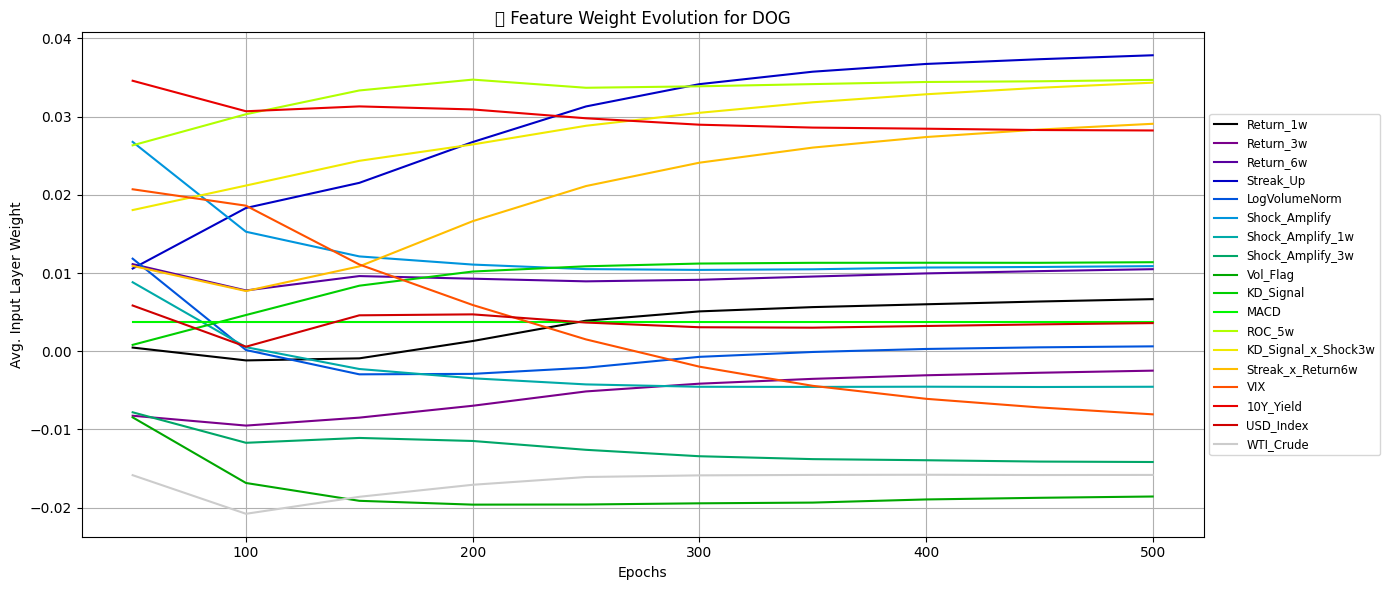

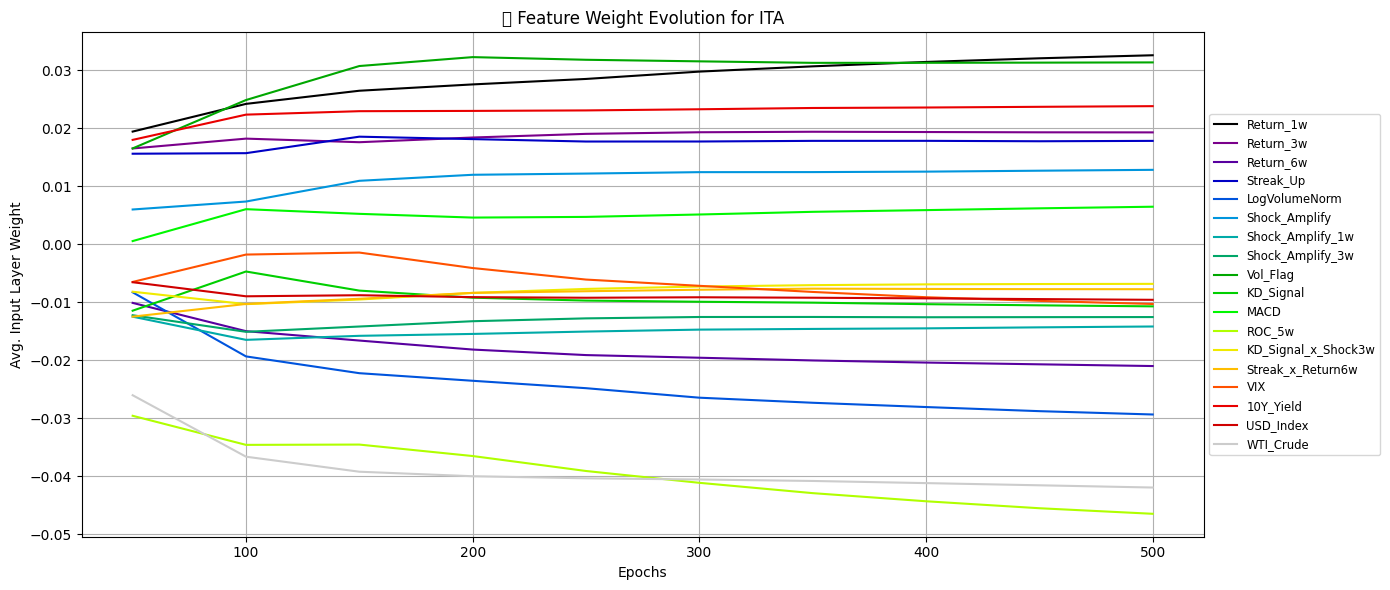

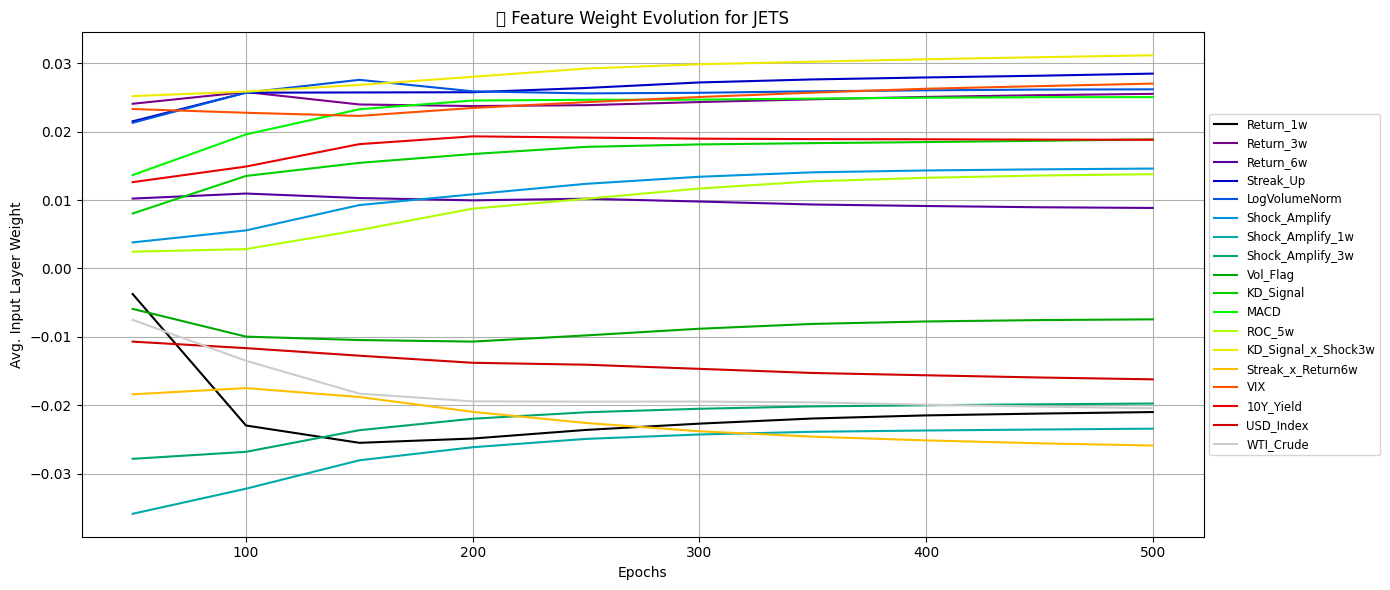

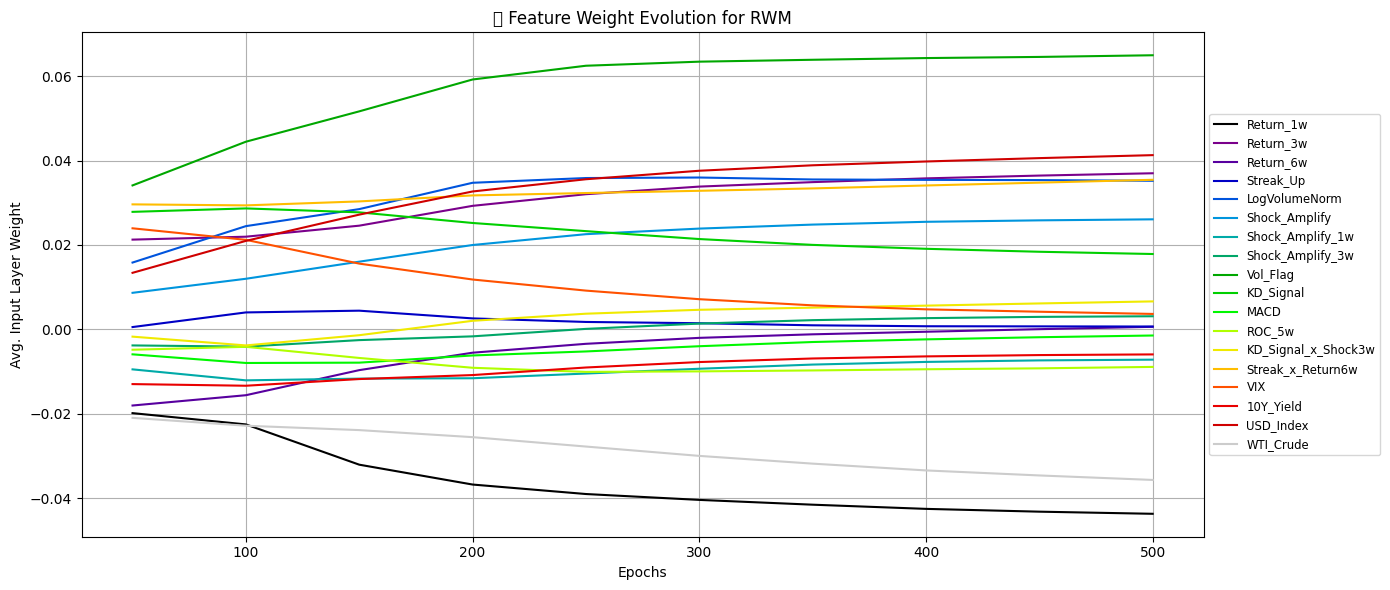

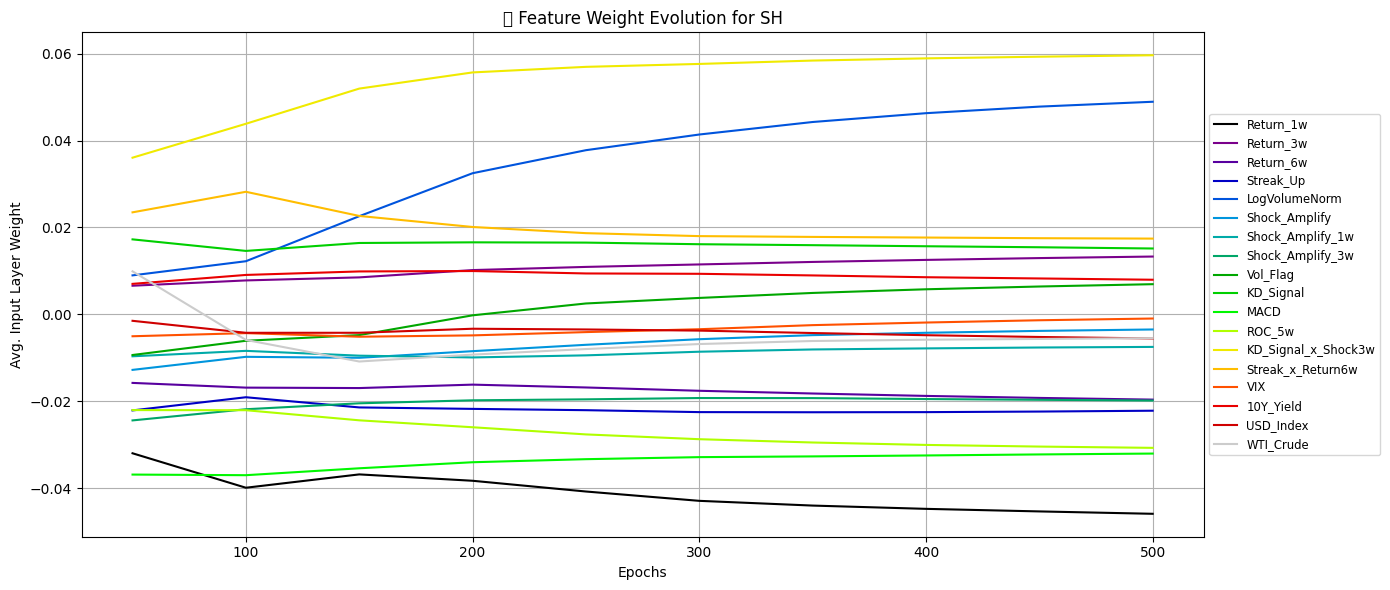

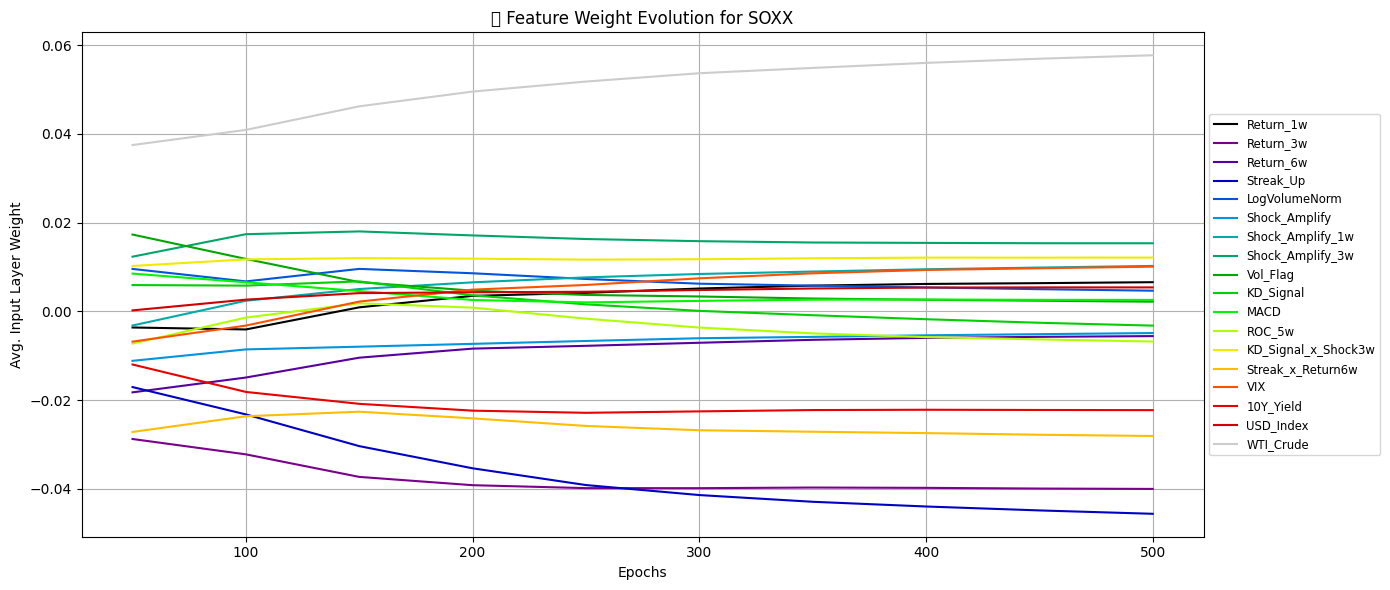

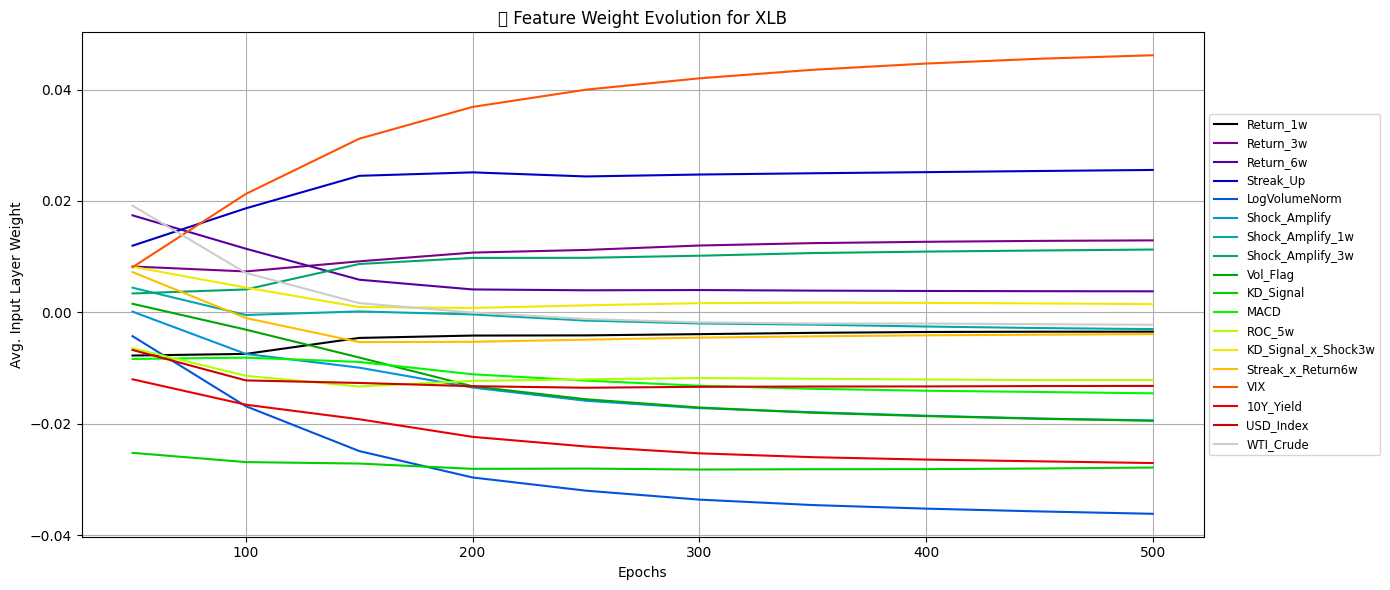

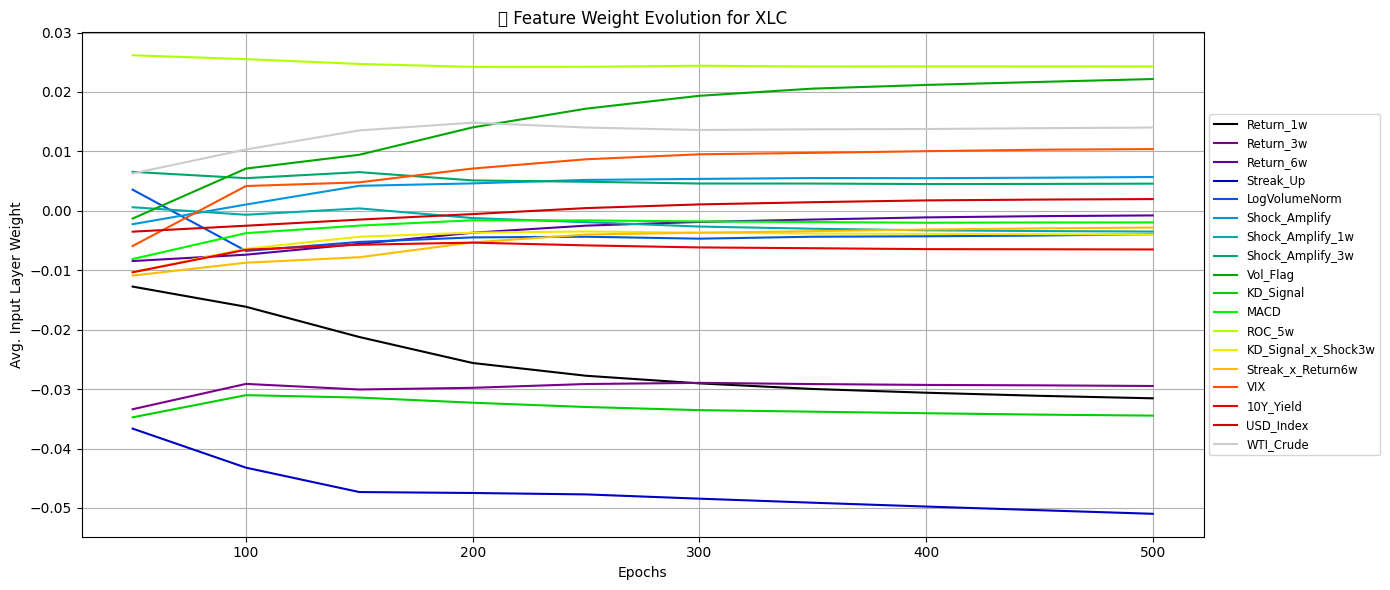

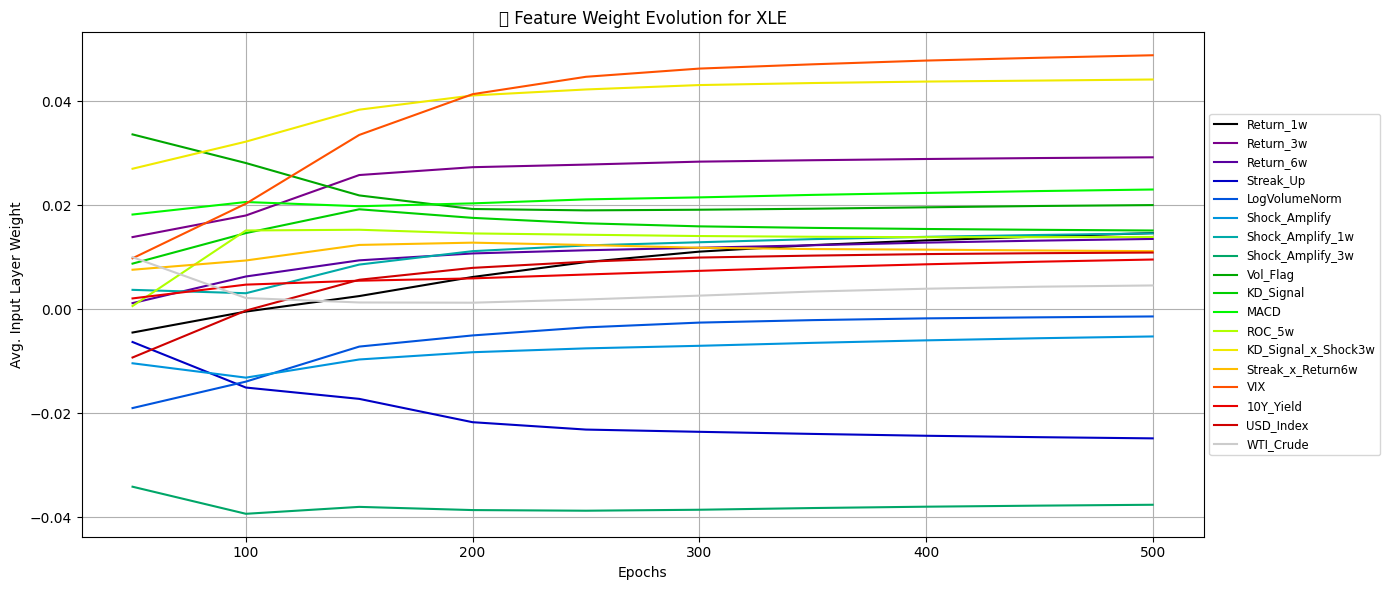

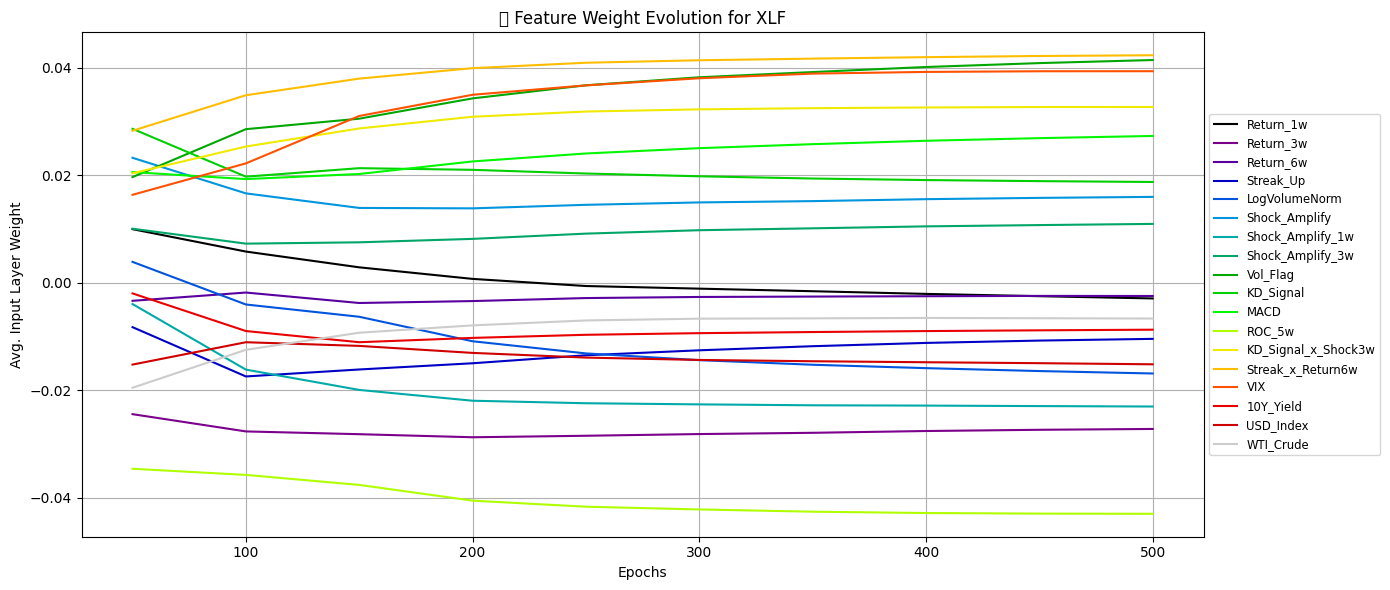

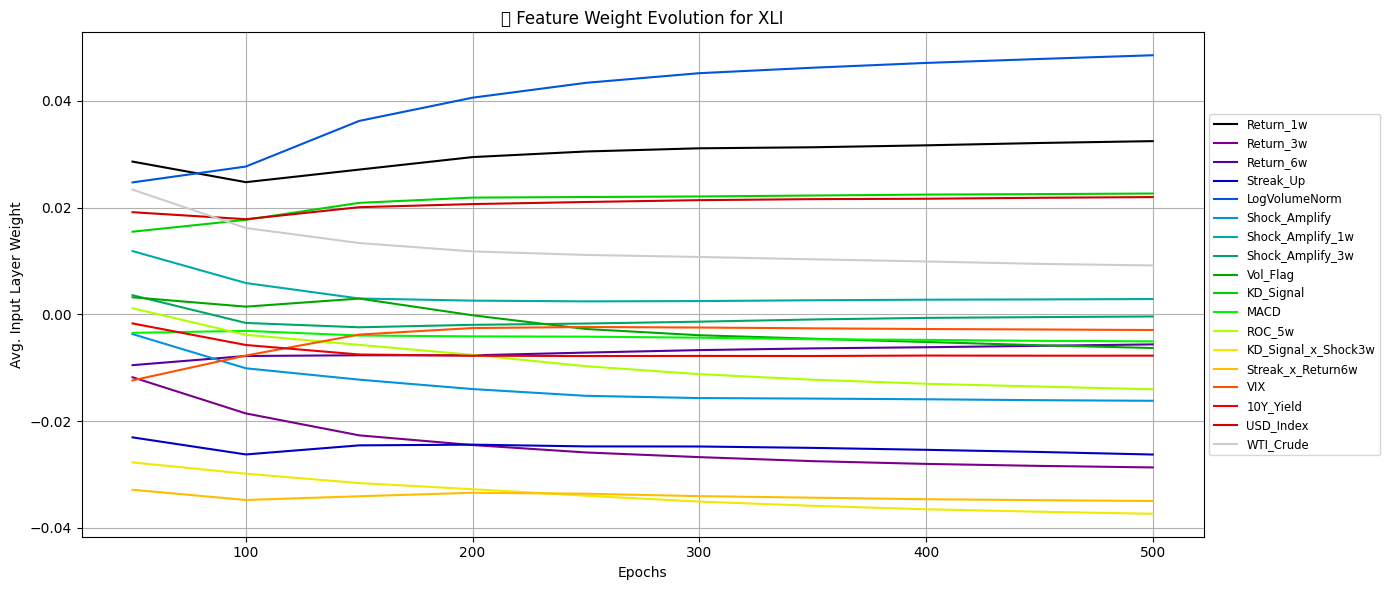

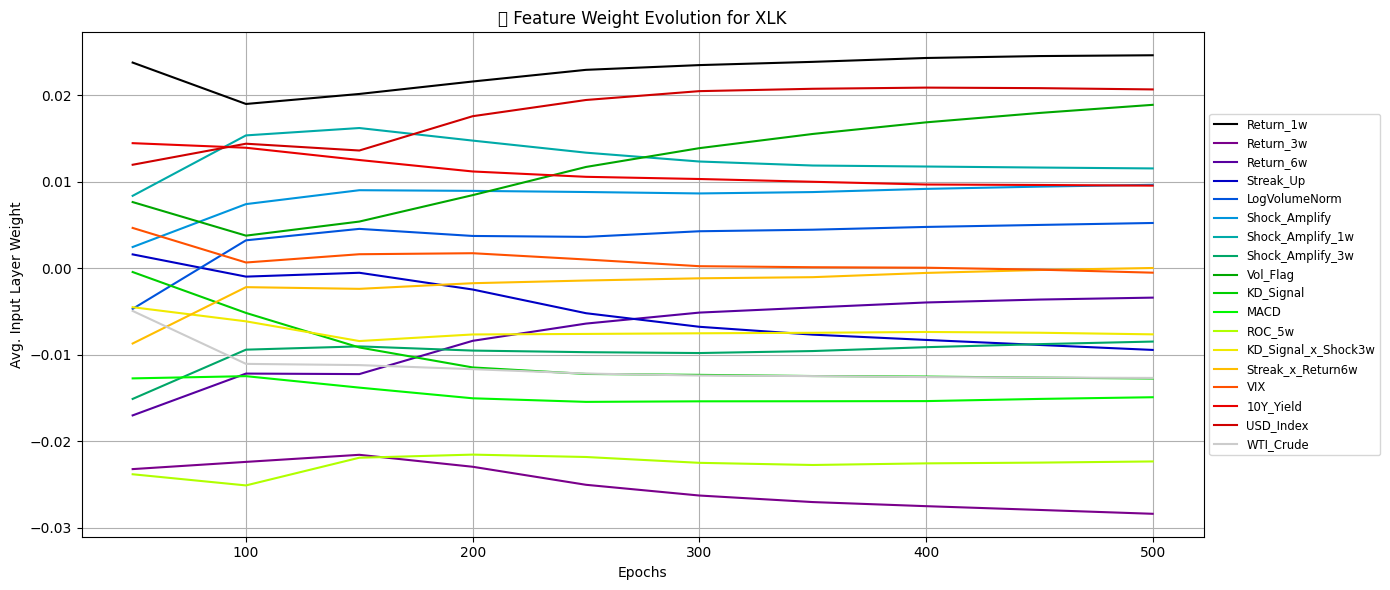

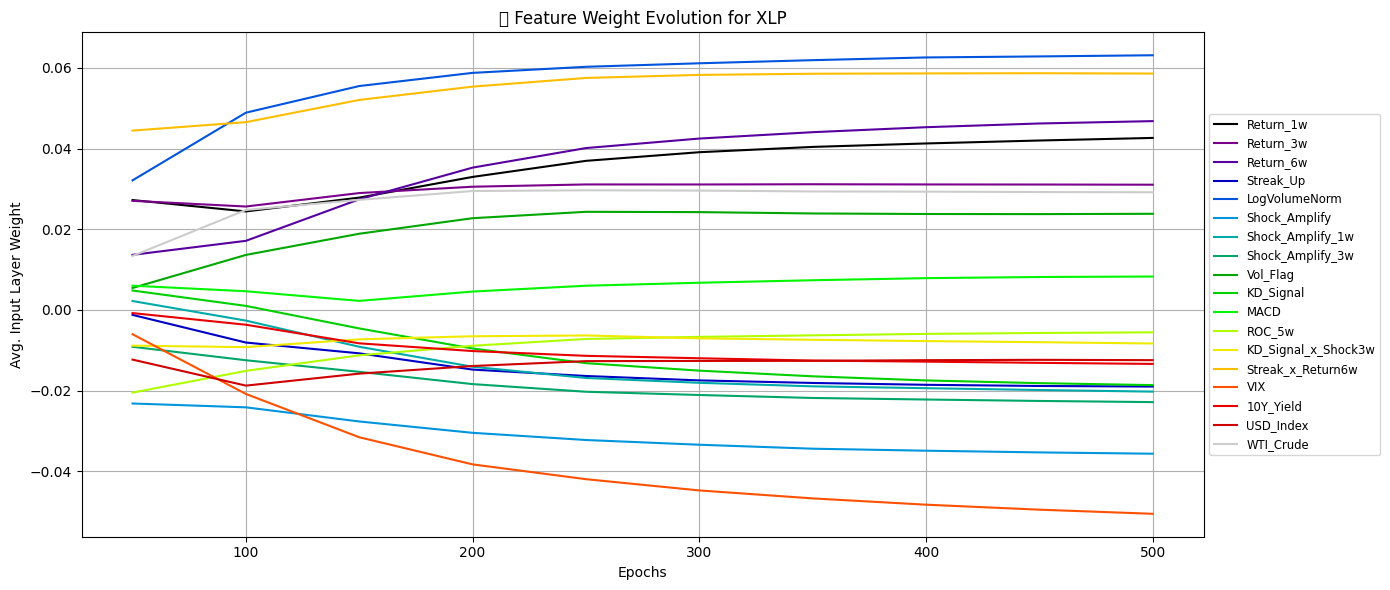

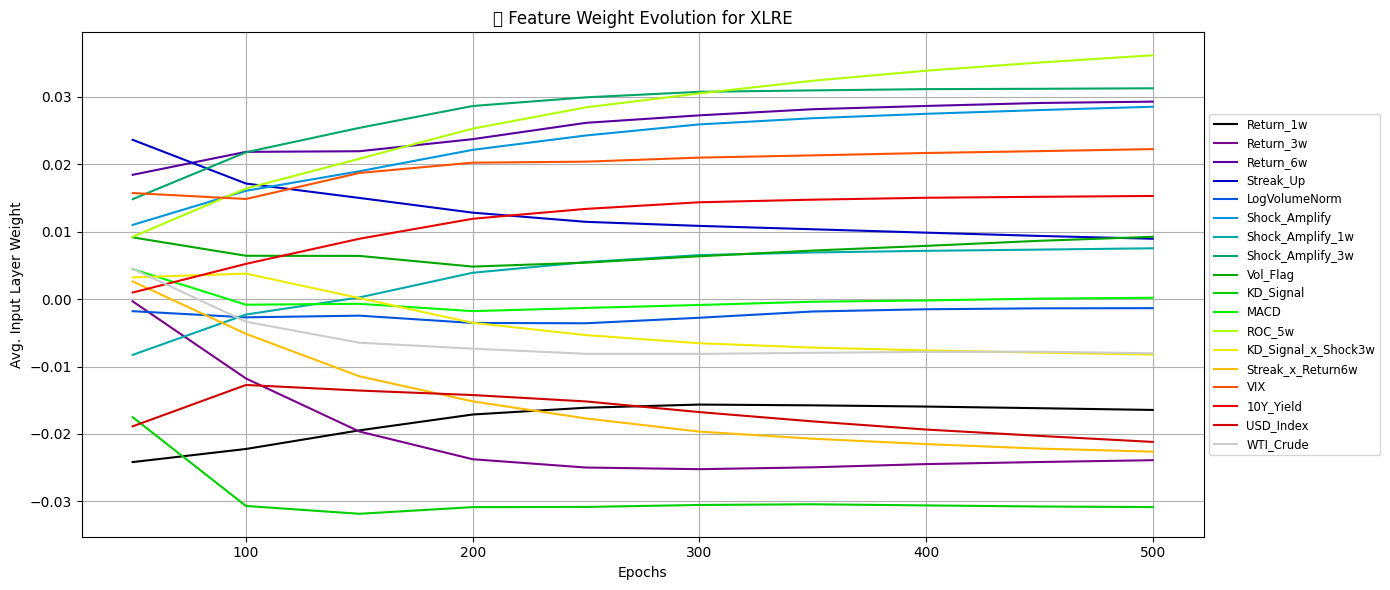

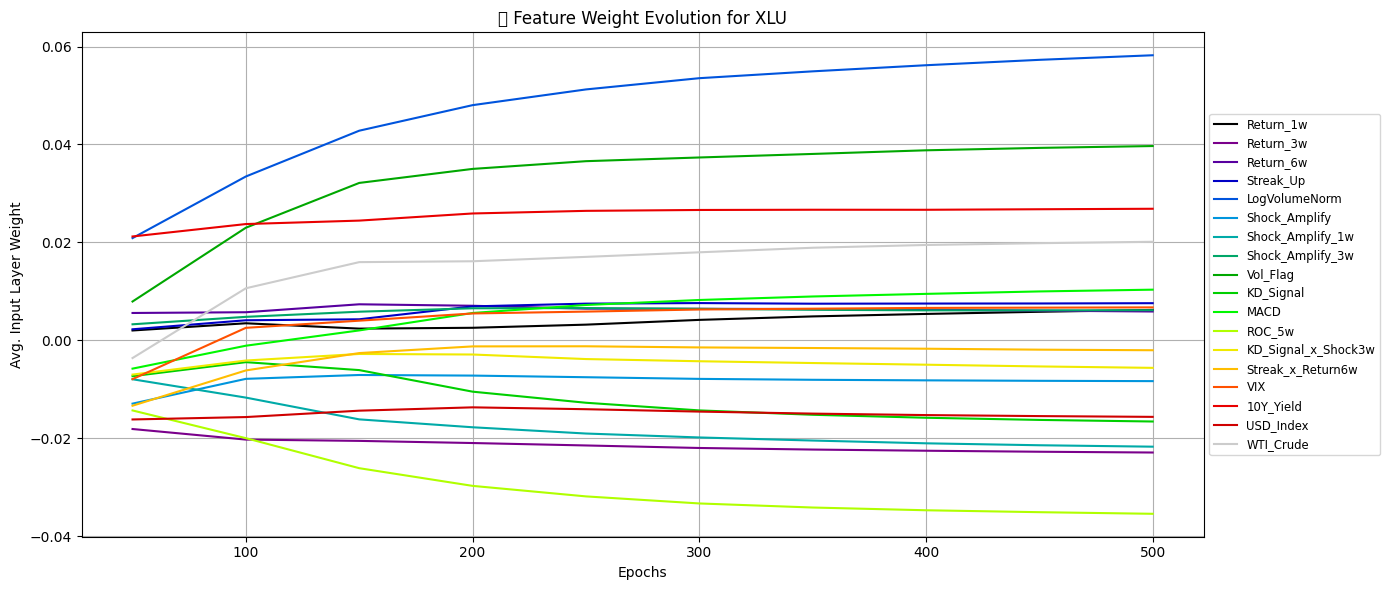

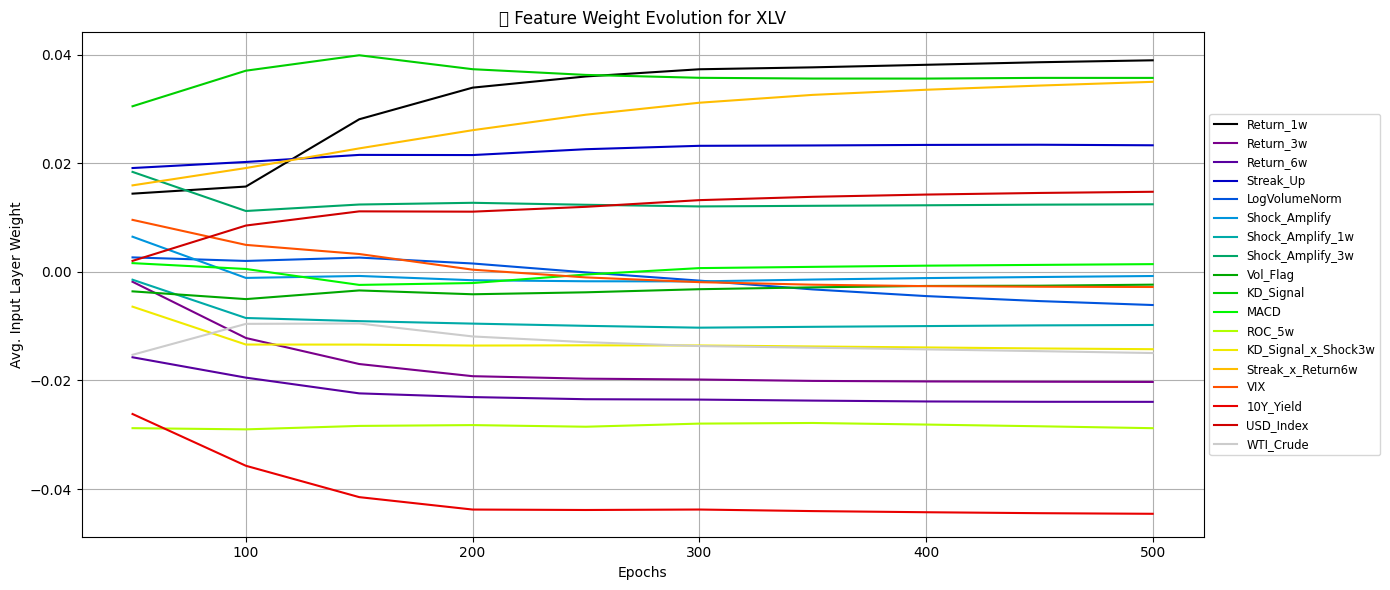

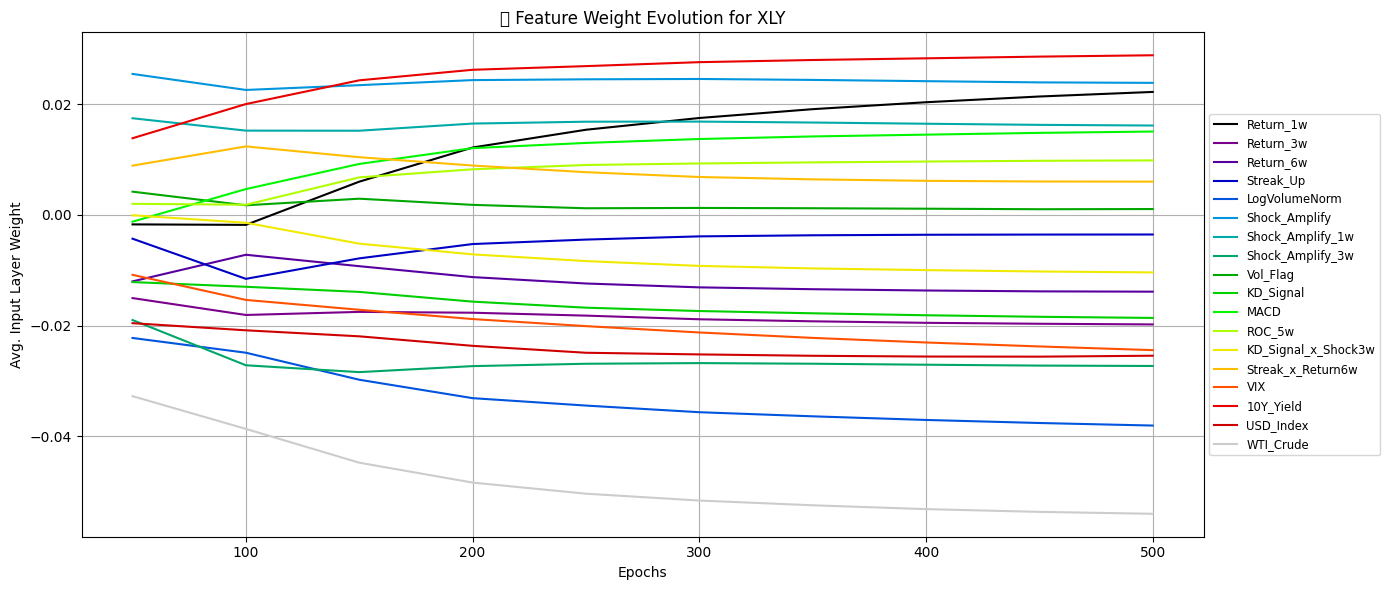

In [269]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# === Updated to match your training features ===
feature_names = [
    'Return_1w', 'Return_3w', 'Return_6w', 'Streak_Up',
    'LogVolumeNorm', 'Shock_Amplify', 'Shock_Amplify_1w', 'Shock_Amplify_3w',
    'Vol_Flag', 'KD_Signal', 'MACD', 'ROC_5w',
    'KD_Signal_x_Shock3w', 'Streak_x_Return6w',
    'VIX', '10Y_Yield', 'USD_Index', 'WTI_Crude'
]

# === Color mapping for features ===
cmap = cm.get_cmap('nipy_spectral', len(feature_names))

# === Plot evolution per ETF ===
for etf, snapshots in weight_snapshots.items():
    if not snapshots:
        continue

    try:
        # Try to extract input weights
        fc1_weights = [s['shared.0.weight'].cpu().numpy() for s in snapshots if 'shared.0.weight' in s]
        weight_matrix = np.stack(fc1_weights)  # shape: (n_snapshots, n_nodes, n_features)
        avg_weights = weight_matrix.mean(axis=1)  # shape: (n_snapshots, n_features)
    except Exception as e:
        print(f"⚠️ Skipped {etf} due to error: {e}")
        continue

    plt.figure(figsize=(14, 6))
    for i, fname in enumerate(feature_names):
        try:
            plt.plot(
                range(50, 50 * (len(fc1_weights) + 1), 50),
                avg_weights[:, i],
                label=fname,
                color=cmap(i)
            )
        except IndexError:
            print(f"⚠️ Skipped feature '{fname}' for {etf} due to shape mismatch.")
            continue

    plt.title(f"📈 Feature Weight Evolution for {etf}")
    plt.xlabel("Epochs")
    plt.ylabel("Avg. Input Layer Weight")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_46752\2264829814.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


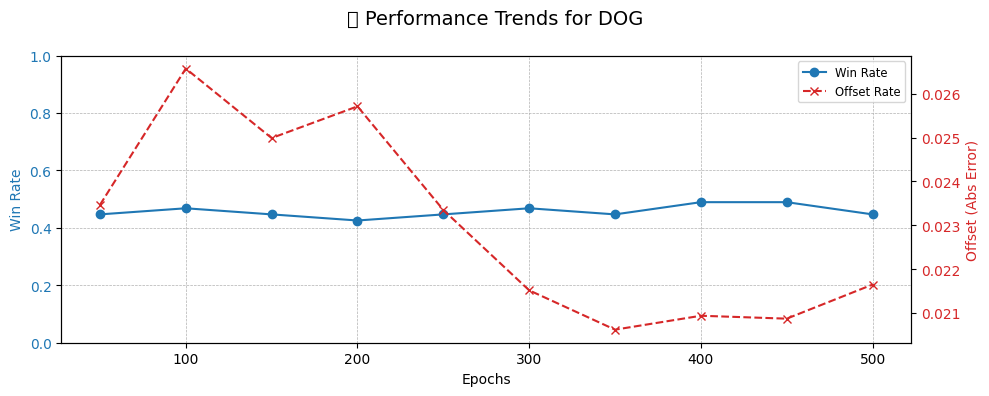

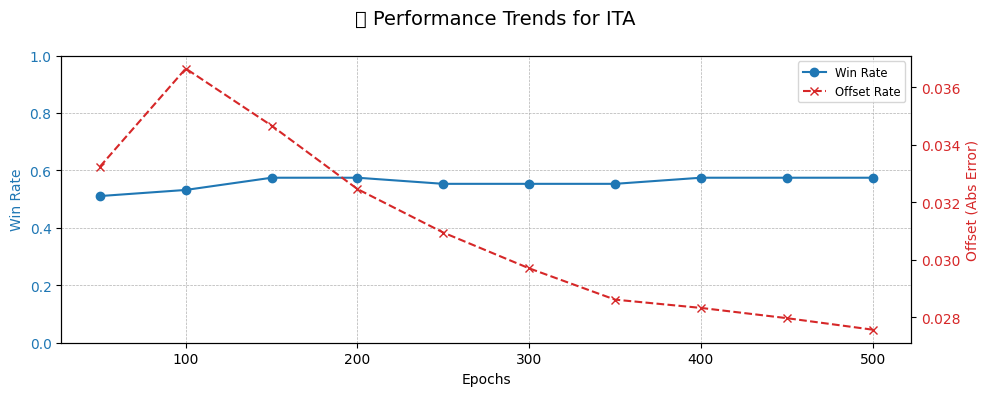

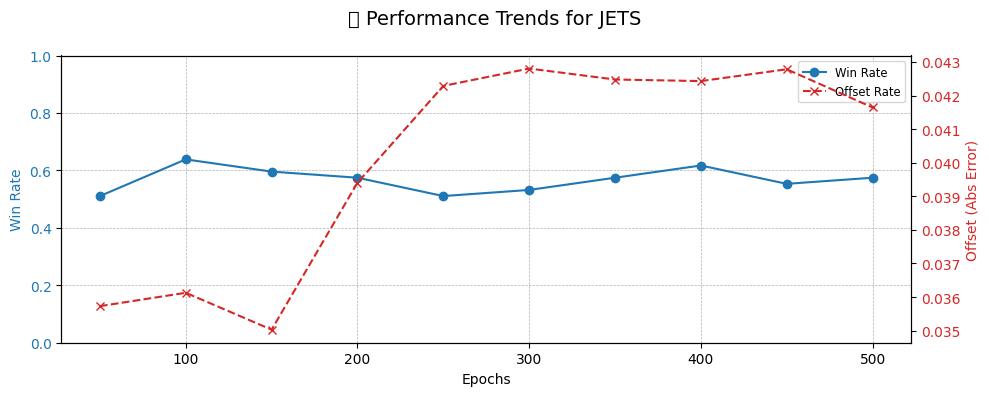

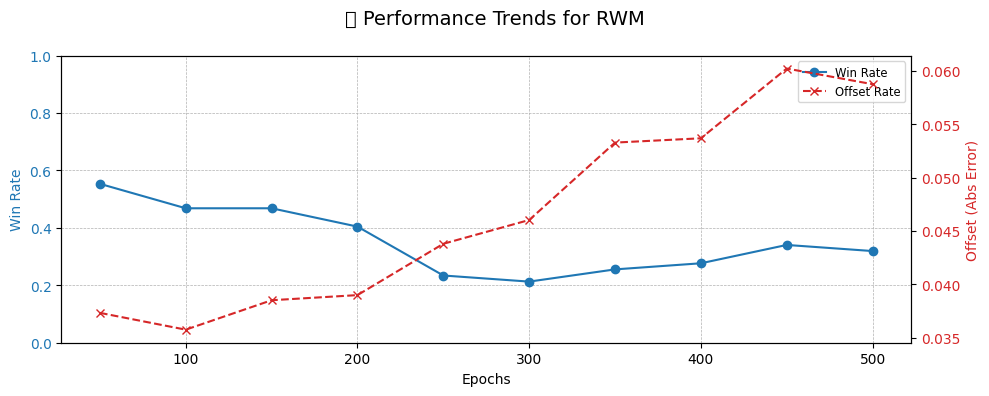

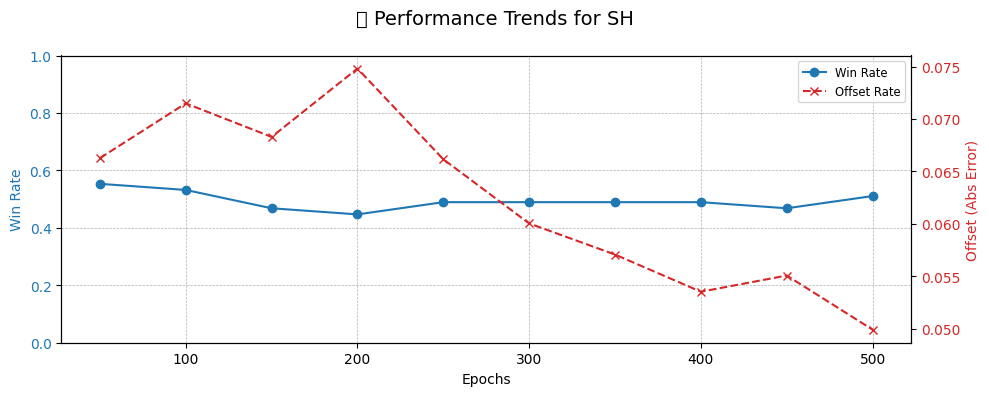

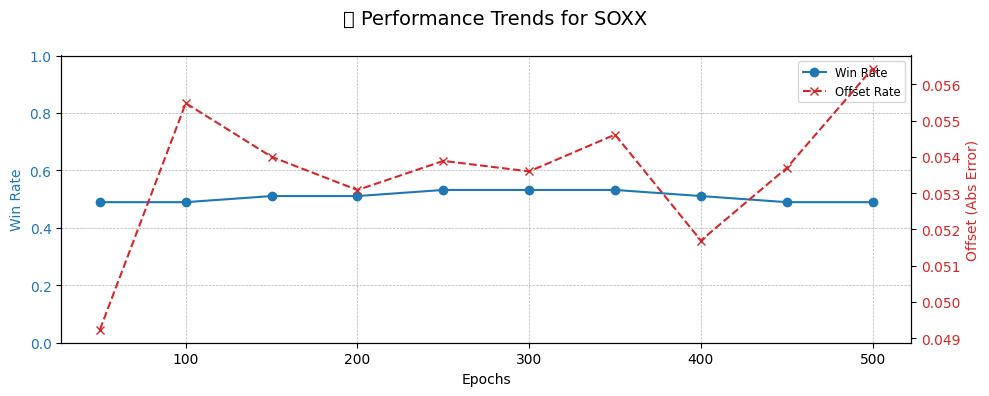

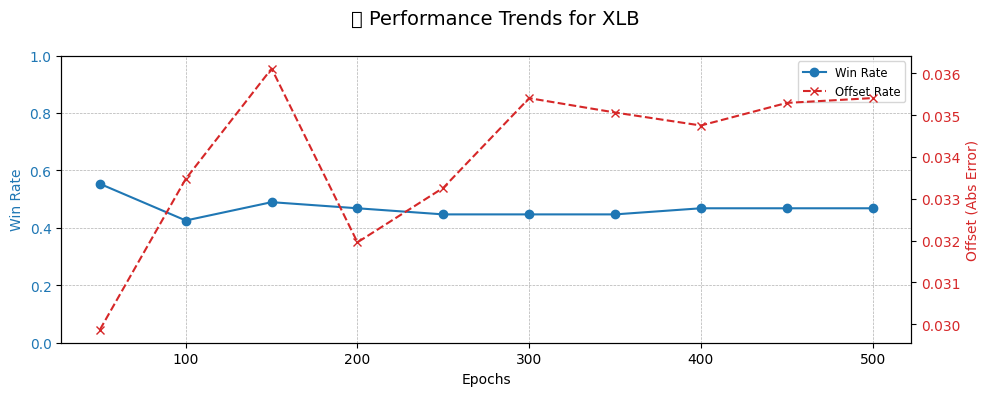

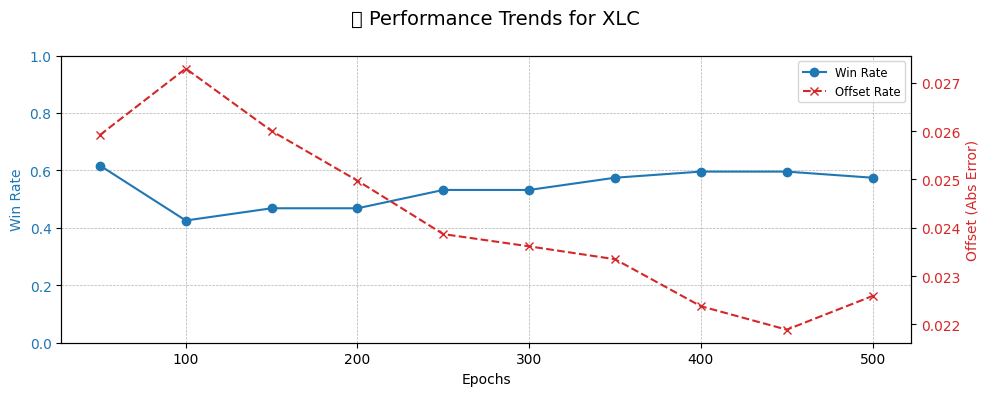

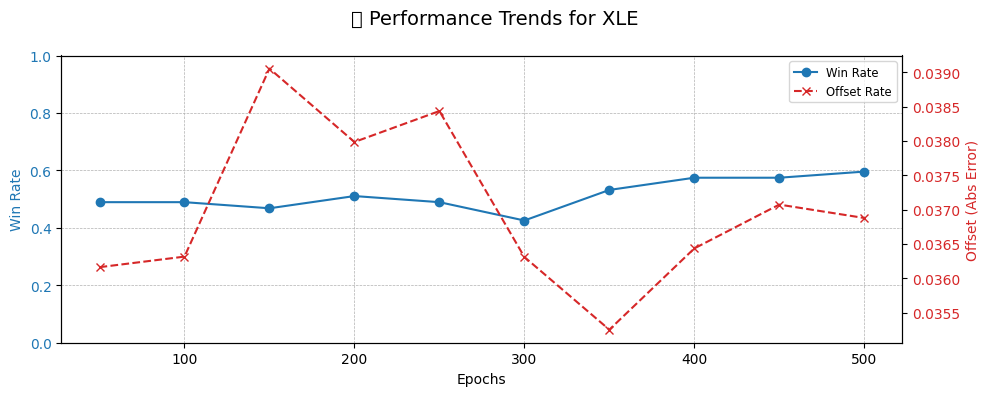

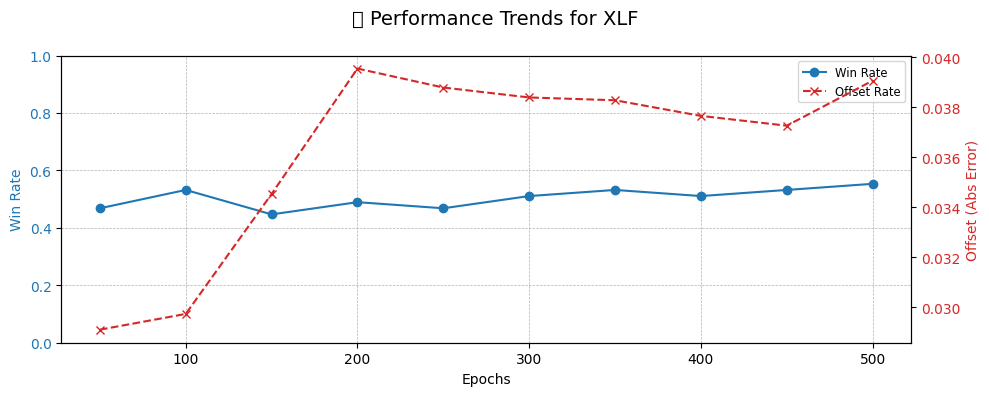

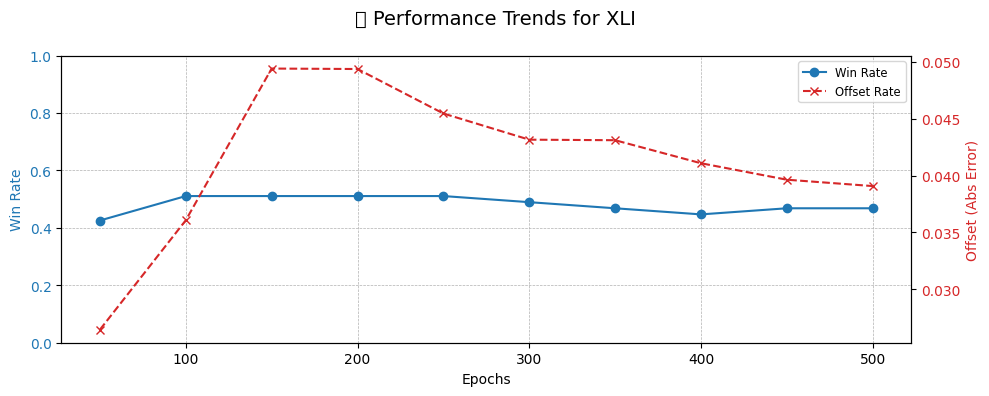

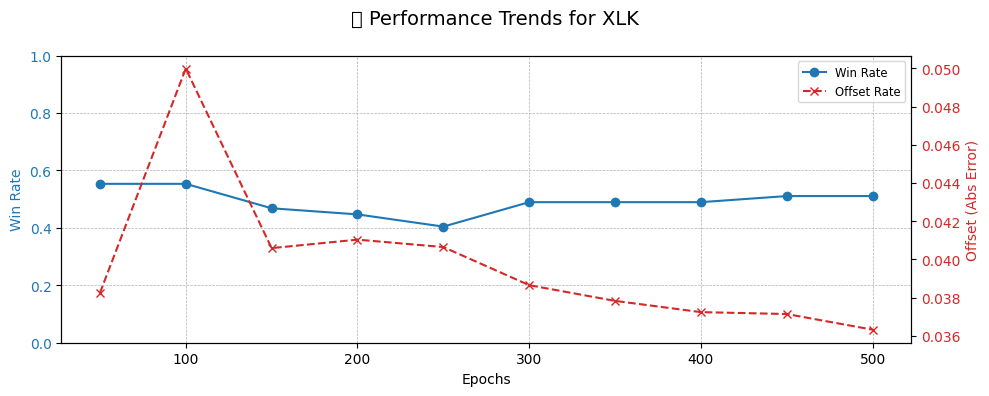

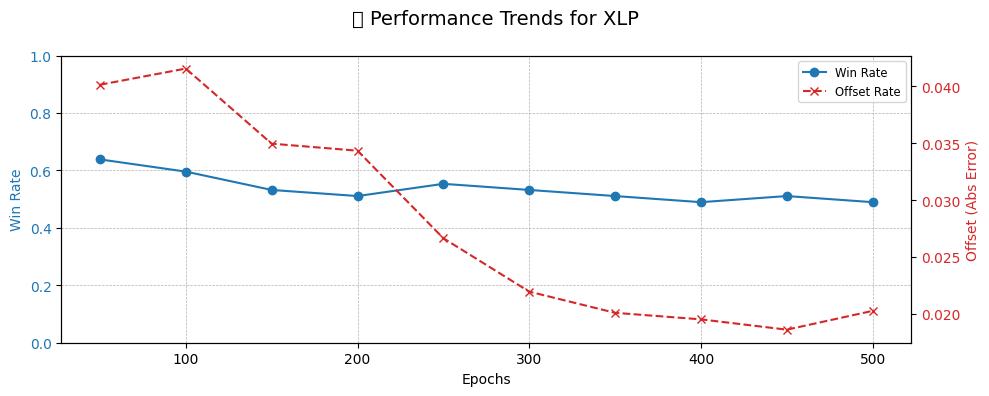

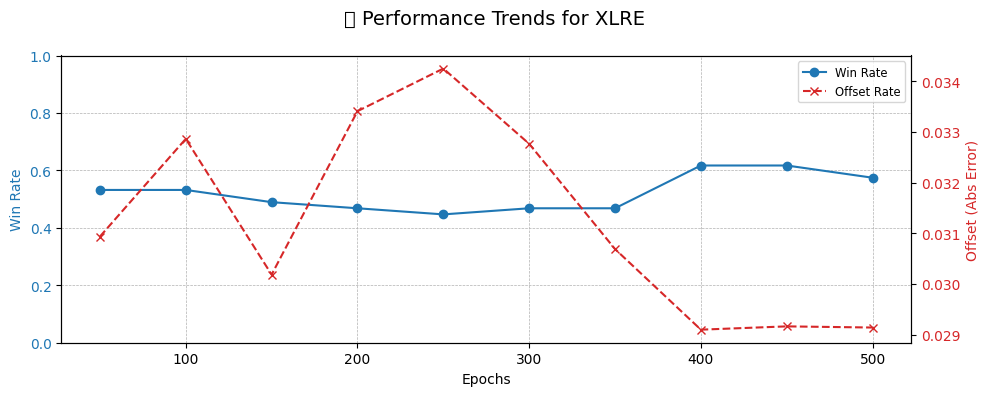

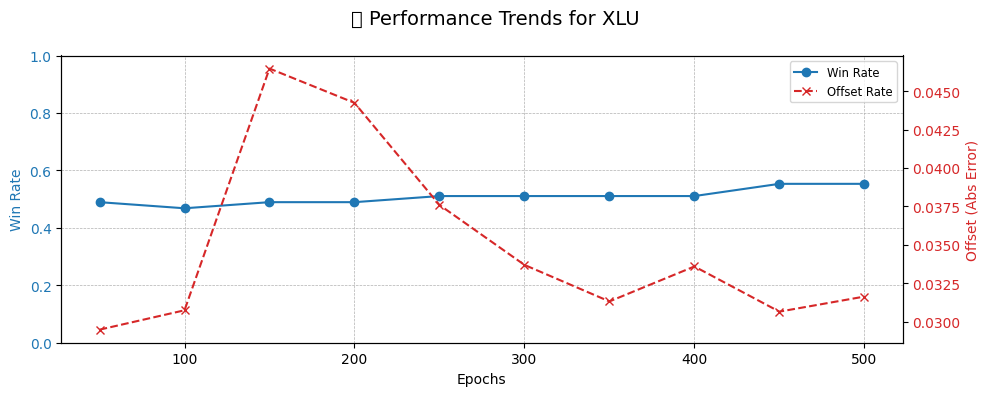

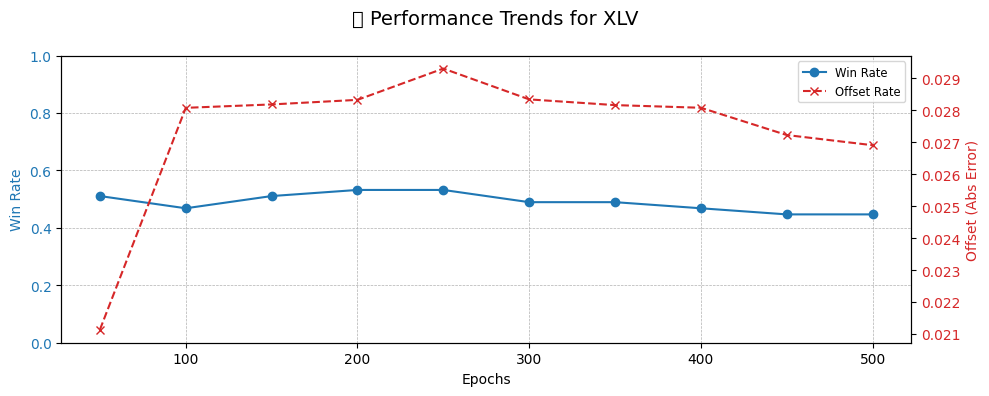

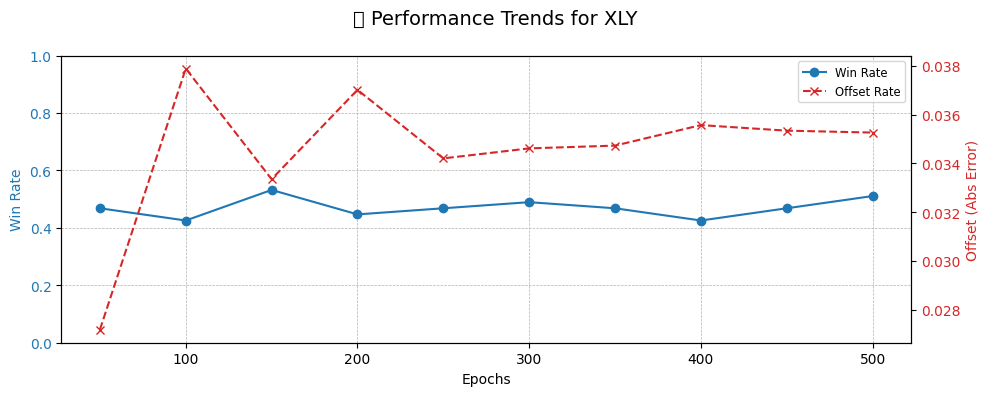

In [270]:
import matplotlib.pyplot as plt

# === Plot Win Rate and Offset for Each ETF ===
for etf in win_rate_history.keys():
    win_data = win_rate_history[etf]
    offset_data = offset_history[etf]

    if not win_data or not offset_data:
        continue

    # Unpack epoch-wise values
    epochs_win, win_values = zip(*win_data)
    epochs_offset, offset_values = zip(*offset_data)

    fig, ax1 = plt.subplots(figsize=(10, 4))
    fig.suptitle(f"📊 Performance Trends for {etf}", fontsize=14)

    # Left Y-axis: Win Rate
    ax1.plot(epochs_win, win_values, color='tab:blue', marker='o', label="Win Rate")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Win Rate", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 1)
    ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

    # Right Y-axis: Offset Rate
    ax2 = ax1.twinx()
    ax2.plot(epochs_offset, offset_values, color='tab:red', linestyle='--', marker='x', label="Offset Rate")
    ax2.set_ylabel("Offset (Abs Error)", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Combined legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_46752\505412260.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


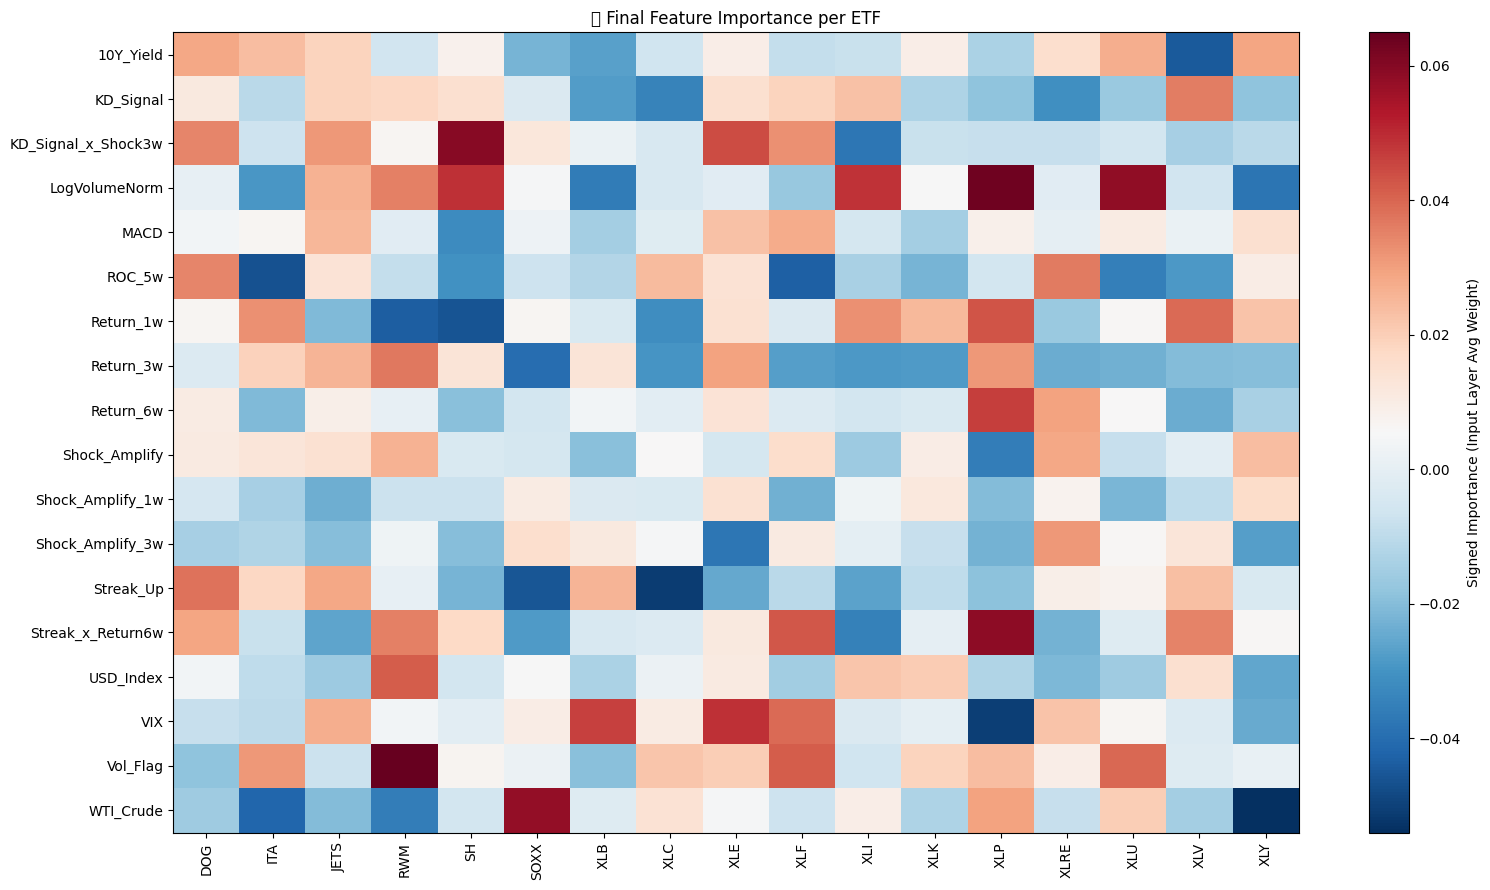

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Match enhanced model features ===
feature_names = [
    'Return_1w', 'Return_3w', 'Return_6w', 'Streak_Up',
    'LogVolumeNorm', 'Shock_Amplify', 'Shock_Amplify_1w', 'Shock_Amplify_3w',
    'Vol_Flag', 'KD_Signal',
    'MACD', 'ROC_5w', 'KD_Signal_x_Shock3w', 'Streak_x_Return6w',
    'VIX', '10Y_Yield', 'USD_Index', 'WTI_Crude'
]

importance_records = []

# === Collect average input weights for each ETF from final snapshot ===
for etf, snapshots in weight_snapshots.items():
    if not snapshots:
        continue

    final_state = snapshots[-1]  # last saved state dict
    key = 'shared.0.weight'

    if key not in final_state:
        print(f"⚠️ {key} not found in snapshot for {etf}")
        continue

    fc1_weight = final_state[key].cpu().numpy()  # shape: (n_hidden, n_features)
    avg_weight = fc1_weight.mean(axis=0)  # → (n_features,)

    for i, fname in enumerate(feature_names):
        importance_records.append({
            'ETF': etf,
            'Feature': fname,
            'Weight': avg_weight[i],
            'AbsImportance': abs(avg_weight[i])
        })

# === Assemble into DataFrame ===
importance_df = pd.DataFrame(importance_records)

# === Pivot for heatmap ===
heatmap_df = importance_df.pivot(index='Feature', columns='ETF', values='Weight')

# === Plot heatmap ===
plt.figure(figsize=(16, 9))
im = plt.imshow(heatmap_df.values, aspect='auto', cmap='RdBu_r', interpolation='nearest')

plt.colorbar(im, label='Signed Importance (Input Layer Avg Weight)')
plt.xticks(np.arange(len(heatmap_df.columns)), heatmap_df.columns, rotation=90)
plt.yticks(np.arange(len(heatmap_df.index)), heatmap_df.index)
plt.title("📊 Final Feature Importance per ETF")
plt.tight_layout()
plt.grid(False)
plt.show()


In [272]:
import copy
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from IPython.display import display

# === Function: Average top-k weight states based on win rate ===
def average_top_k_weights_by_win(snapshot_list, k=5):
    top_k = sorted(snapshot_list, key=lambda s: s['win'], reverse=True)[:k]
    avg_state = {}

    for key in top_k[0]['weights'].keys():
        avg_state[key] = sum([s['weights'][key] for s in top_k]) / k
    return avg_state

# === Containers for evaluation ===
averaged_results = []
averaged_predictions = []

# === Evaluate each ETF with top-5 averaged weights ===
for etf in performance_snapshots:
    snapshots = performance_snapshots[etf]
    if len(snapshots) < 5:
        continue

    # Attach model weights to performance snapshots
    for i, snap in enumerate(snapshots):
        snap['weights'] = weight_snapshots[etf][i]

    avg_weights = average_top_k_weights_by_win(snapshots, k=5)

    # Prepare test set
    df = etf_groups.get_group(etf).sort_values('Date').reset_index(drop=True)
    split = int(len(df) * 0.8)
    test_df = df.iloc[split:]
    X_test = test_df[features].values
    y_test_reg = test_df[target].values
    y_test_cls = test_df[target_cls].values

    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Load model and assign averaged weights
    model = MLPDualOutput(input_dim=len(features)).to(device)
    model.load_state_dict(avg_weights)
    model.eval()

    with torch.no_grad():
        y_pred_reg, y_pred_cls = model(X_test_tensor.to(device))
        y_pred = y_pred_reg.cpu().numpy().flatten()
        y_cls_pred = (y_pred_cls.cpu().numpy().flatten() > 0.5).astype(int)

    # Metrics
    mae = np.mean(np.abs(y_test_reg - y_pred))
    mse = np.mean((y_test_reg - y_pred) ** 2)
    win_rate = np.mean(np.sign(y_pred) == np.sign(y_test_reg))
    acc = accuracy_score(y_test_cls, y_cls_pred)

    print(f"[{etf}] 🎯 Avg Top-5 by Win → MAE: {mae:.5f}, WinRate: {win_rate:.2%}, Accuracy: {acc:.2%}")

    # Store results
    averaged_results.append({
        'ETF': etf,
        'MAE': mae,
        'MSE': mse,
        'Win_Rate': win_rate,
        'Direction_Acc': acc,
        'Samples': len(df)
    })

    # Save predictions
    post_df = test_df.copy()
    post_df['Predicted'] = y_pred
    post_df['Predicted_Direction'] = y_cls_pred
    post_df['Correct_Direction'] = (y_cls_pred == y_test_cls)
    post_df['ETF'] = etf
    averaged_predictions.append(post_df)

# === Display summary ===
avg_df = pd.DataFrame(averaged_results).sort_values('MAE')
display(avg_df)

# === Store predictions (for optional plotting) ===
averaged_test_df = pd.concat(averaged_predictions).reset_index(drop=True)


[DOG] 🎯 Avg Top-5 by Win → MAE: 0.03475, WinRate: 48.94%, Accuracy: 42.55%
[ITA] 🎯 Avg Top-5 by Win → MAE: 0.02870, WinRate: 53.19%, Accuracy: 42.55%
[JETS] 🎯 Avg Top-5 by Win → MAE: 0.04654, WinRate: 51.06%, Accuracy: 53.19%
[RWM] 🎯 Avg Top-5 by Win → MAE: 0.03627, WinRate: 46.81%, Accuracy: 48.94%
[SH] 🎯 Avg Top-5 by Win → MAE: 0.07386, WinRate: 48.94%, Accuracy: 46.81%
[SOXX] 🎯 Avg Top-5 by Win → MAE: 0.05199, WinRate: 55.32%, Accuracy: 53.19%
[XLB] 🎯 Avg Top-5 by Win → MAE: 0.03549, WinRate: 51.06%, Accuracy: 44.68%
[XLC] 🎯 Avg Top-5 by Win → MAE: 0.03425, WinRate: 55.32%, Accuracy: 53.19%
[XLE] 🎯 Avg Top-5 by Win → MAE: 0.04955, WinRate: 44.68%, Accuracy: 53.19%
[XLF] 🎯 Avg Top-5 by Win → MAE: 0.03037, WinRate: 65.96%, Accuracy: 51.06%
[XLI] 🎯 Avg Top-5 by Win → MAE: 0.04248, WinRate: 44.68%, Accuracy: 48.94%
[XLK] 🎯 Avg Top-5 by Win → MAE: 0.06407, WinRate: 53.19%, Accuracy: 51.06%
[XLP] 🎯 Avg Top-5 by Win → MAE: 0.04733, WinRate: 55.32%, Accuracy: 53.19%
[XLRE] 🎯 Avg Top-5 by Wi

ETF       MAE       MSE  Win_Rate  Direction_Acc  Samples
15   XLV  0.022940  0.000977  0.510638       0.595745      233
14   XLU  0.023699  0.000870  0.553191       0.531915      233
1    ITA  0.028704  0.001489  0.531915       0.425532      233
9    XLF  0.030373  0.001616  0.659574       0.510638      233
16   XLY  0.031978  0.001746  0.510638       0.489362      233
7    XLC  0.034251  0.002101  0.553191       0.531915      233
0    DOG  0.034750  0.001941  0.489362       0.425532      233
6    XLB  0.035488  0.001914  0.510638       0.446809      233
3    RWM  0.036270  0.002411  0.468085       0.489362      233
10   XLI  0.042484  0.002667  0.446809       0.489362      233
2   JETS  0.046536  0.004193  0.510638       0.531915      233
12   XLP  0.047325  0.003752  0.553191       0.531915      233
8    XLE  0.049553  0.003903  0.446809       0.531915      233
5   SOXX  0.051989  0.004674  0.553191       0.531915      233
13  XLRE  0.053094  0.004706  0.489362       0.489362      233
11   XLK  0.064070  0.006288  0.531915       0.510638      233
4     SH  0.073855  0.016408  0.489362       0.468085      233

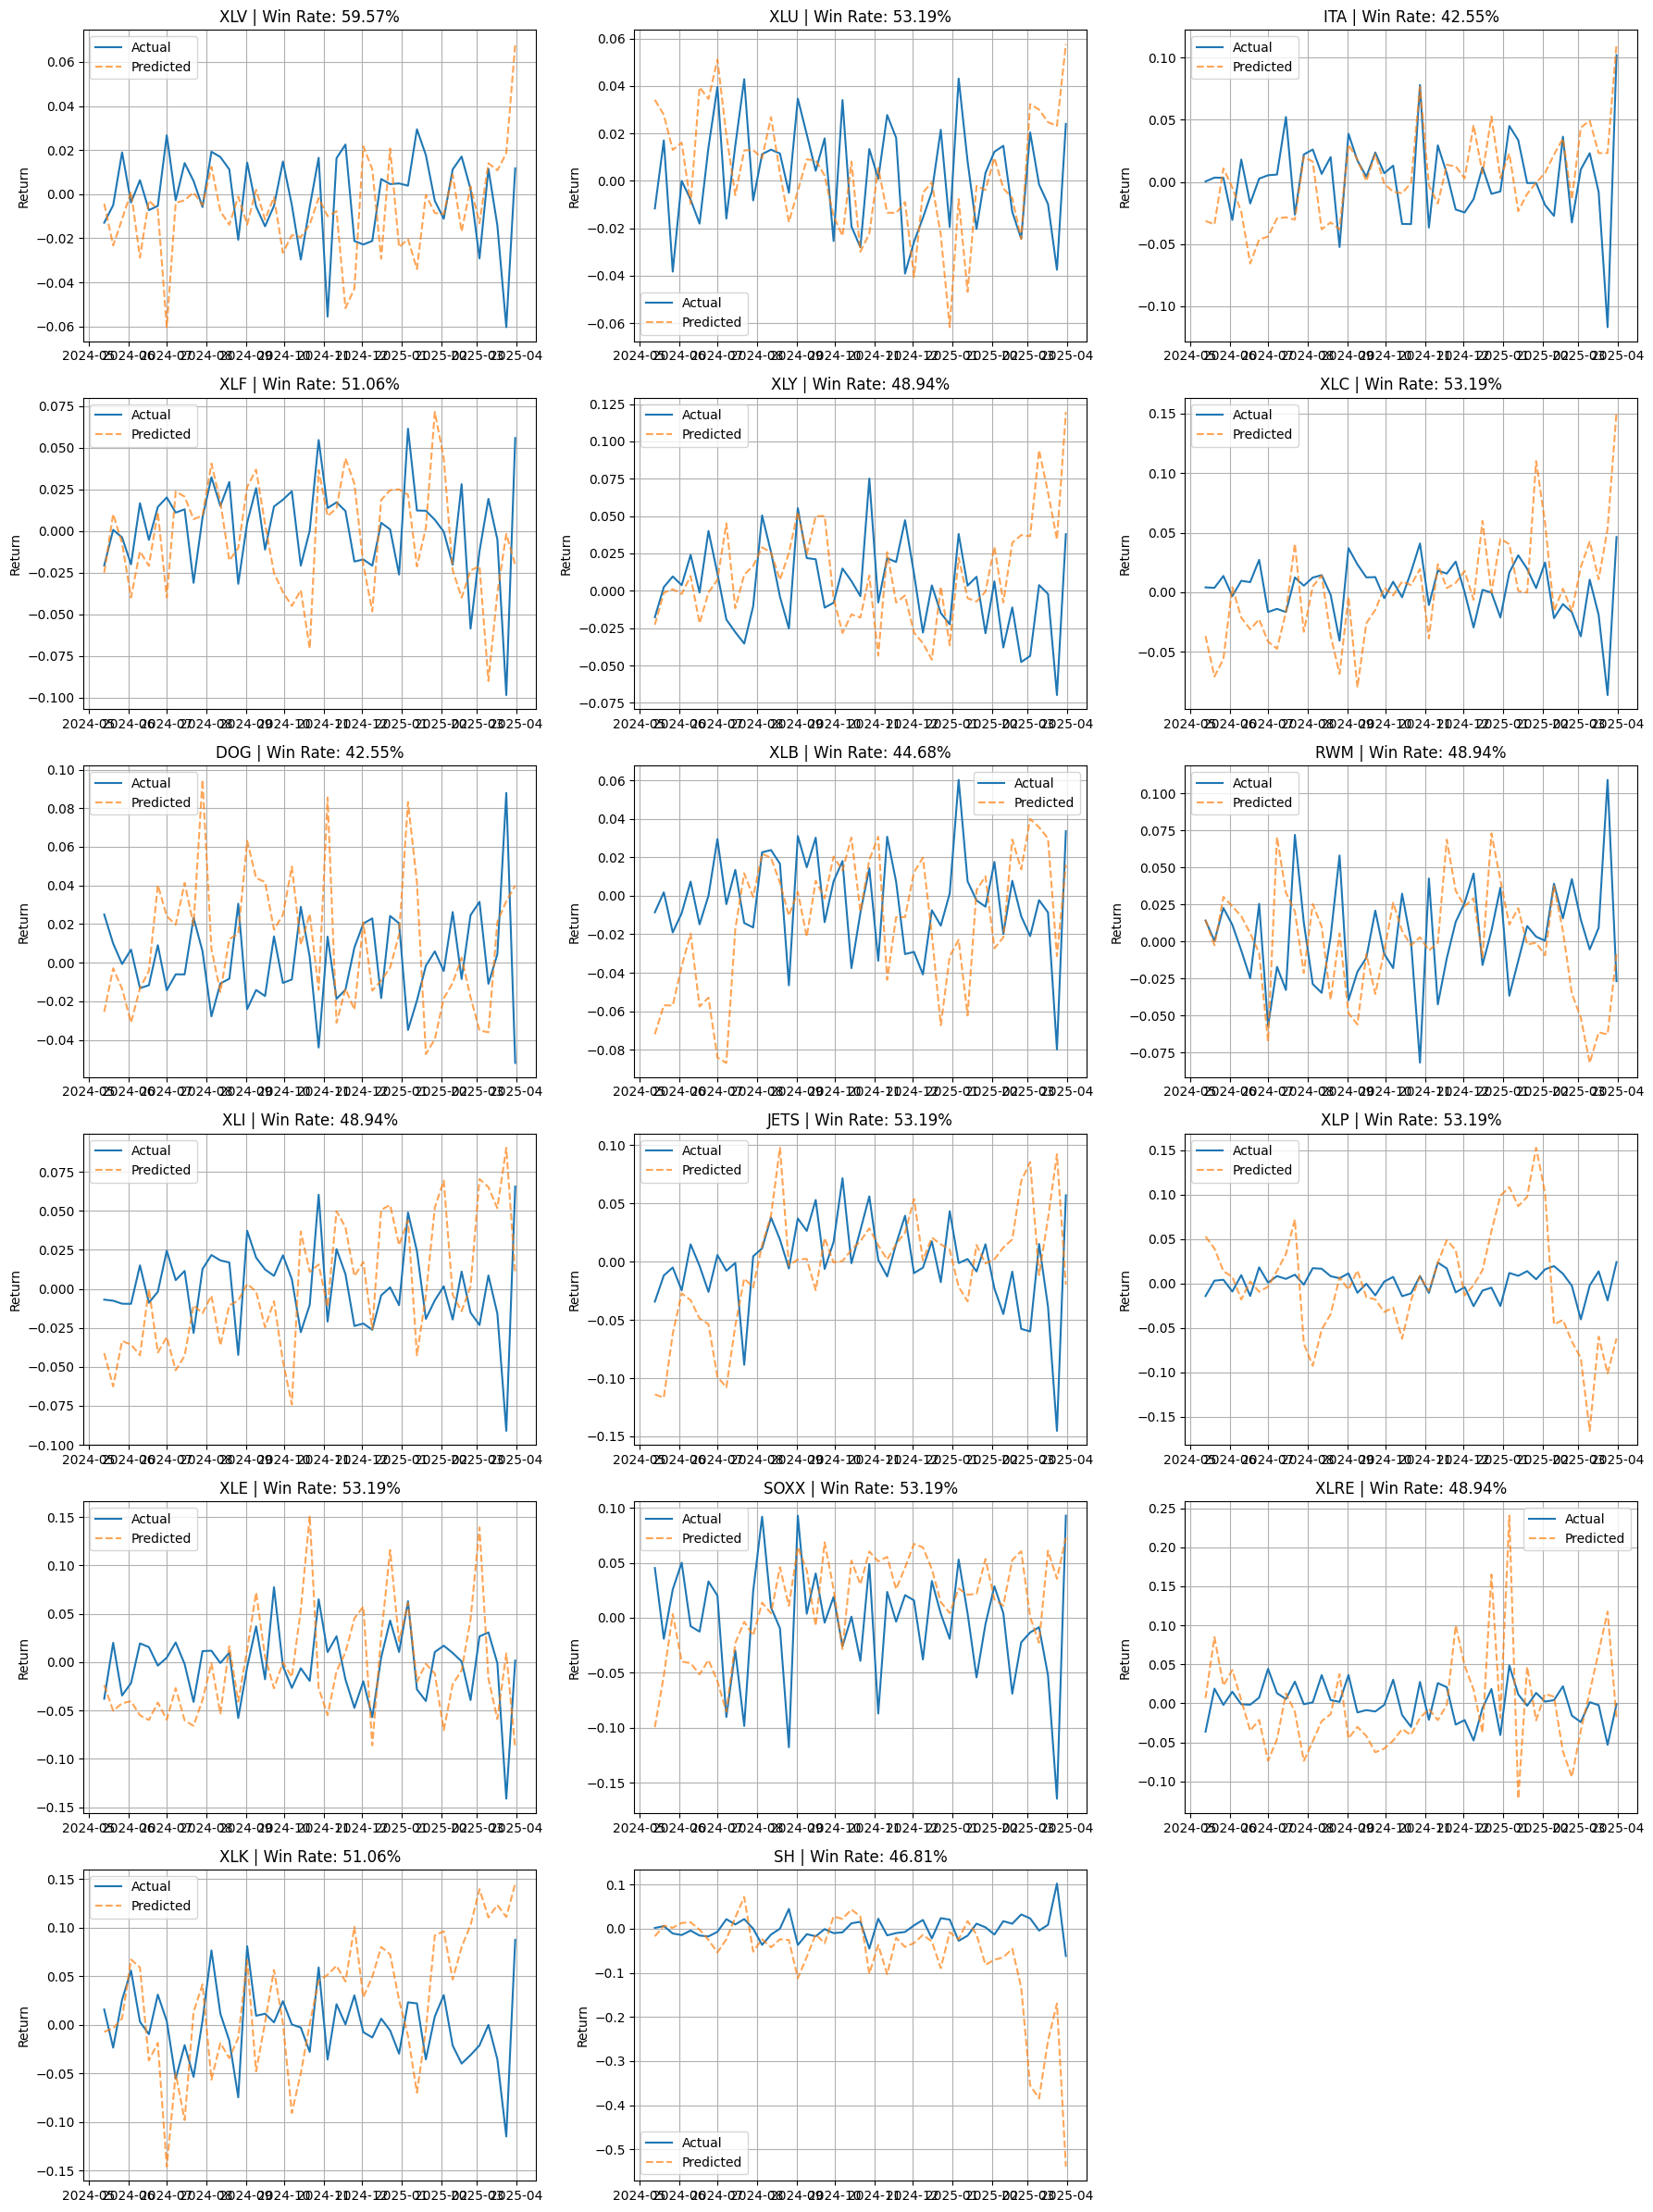

In [273]:
import matplotlib.pyplot as plt
import numpy as np

# === Plot averaged predictions ===
ncols = 3
nrows = -(-len(avg_df) // ncols)  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows), sharex=False)
axes = axes.flatten()

for i, etf in enumerate(avg_df['ETF']):
    etf_data = averaged_test_df[averaged_test_df['ETF'] == etf]
    if etf_data.empty or 'Predicted' not in etf_data.columns:
        continue

    axes[i].plot(etf_data['Date'], etf_data['Target_Next_Week_Return'], label='Actual', linewidth=1.5)
    axes[i].plot(etf_data['Date'], etf_data['Predicted'], label='Predicted', alpha=0.7, linestyle='--')
    
    winrate = etf_data['Correct_Direction'].mean()
    axes[i].set_title(f"{etf} | Win Rate: {winrate:.2%}")
    axes[i].set_ylabel("Return")
    axes[i].legend()
    axes[i].grid(True)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [274]:
import pandas as pd
import numpy as np
import torch
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler

# === Setup
prediction_date = pd.Timestamp.today().strftime("%Y-%m-%d")
csv_name = f"../dataset/weekly_predictions_{prediction_date.replace('-', '')}.csv"

latest_rows = feature_df.sort_values("Date").groupby("ETF").tail(1).copy().set_index("ETF")
recommendations = []

for etf in latest_rows.index:
    try:
        row = latest_rows.loc[etf]
        X = row[features].values.reshape(1, -1)

        scaler = StandardScaler()
        scaler.fit(feature_df[features])
        X_scaled = scaler.transform(X)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        # Load averaged weights
        snapshots = performance_snapshots[etf]
        for i, snap in enumerate(snapshots):
            snap["weights"] = weight_snapshots[etf][i]
        avg_weights = average_top_k_weights_by_win(snapshots, k=5)

        model = MLPDualOutput(input_dim=len(features)).to(device)
        model.load_state_dict(avg_weights)
        model.eval()

        with torch.no_grad():
            y_reg, y_cls = model(X_tensor.to(device))
            predicted_return = float(y_reg.cpu().item())
            confidence = float(y_cls.cpu().item())

        # Clamp
        clipped_return = np.clip(predicted_return, -0.15, 0.15)
        clipped_conf = np.clip(confidence, 0.0, 1.0)
        score = clipped_return * clipped_conf

        last_price = price_df[etf].dropna().iloc[-1]
        recent_std = price_df[etf].pct_change().dropna().tail(20).std()

        target_high = last_price * (1 + clipped_return)
        stop_loss = last_price * (1 - 2.0 * recent_std) if clipped_return > 0 else last_price * (1 + clipped_return - 1.5 * recent_std)
        stop_loss = min(stop_loss, last_price * 0.98)

        recommendations.append({
            "Prediction_Date": prediction_date,
            "ETF": etf,
            "Score (Return × Confidence)": round(score, 5),
            "Predicted Return": round(clipped_return, 5),
            "Confidence": round(clipped_conf, 5),
            "Current Price": round(last_price, 2),
            "Target Sell High": round(target_high, 2),
            "Stop Loss Price": round(stop_loss, 2)
        })

    except Exception as e:
        print(f"⚠️ {etf} skipped due to error: {e}")

# === Save and Show All Rankings
reco_df = pd.DataFrame(recommendations).sort_values("Score (Return × Confidence)", ascending=False)
reco_df.to_csv(csv_name, index=False)
print(f"✅ All predictions saved to: {csv_name}")

# Show entire sorted table
from IPython.display import display
display(reco_df)


✅ All predictions saved to: ../dataset/weekly_predictions_20250414.csv


c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_46752\3160738720.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recent_std = price_df[etf].pct_change().dropna().tail(20).std()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_46752\3160738720.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future vers

Prediction_Date   ETF  Score (Return × Confidence)  Predicted Return  \
10      2025-04-14  SOXX                      0.14481           0.14481   
14      2025-04-14   XLY                      0.13438           0.13457   
9       2025-04-14   XLK                      0.11599           0.11599   
1       2025-04-14   XLC                      0.10715           0.10715   
2       2025-04-14   DOG                      0.07625           0.08245   
11      2025-04-14   XLI                      0.07080           0.07097   
5       2025-04-14   RWM                      0.06998           0.07229   
13      2025-04-14   XLB                      0.06536           0.07059   
4       2025-04-14   XLV                      0.03196           0.03196   
0       2025-04-14   XLU                      0.02021           0.02021   
12      2025-04-14   XLP                      0.00485           0.01405   
8       2025-04-14   ITA                      0.00004           0.02919   
6       2025-04-14    SH                     -0.00000          -0.11006   
16      2025-04-14  JETS                     -0.00000          -0.13565   
15      2025-04-14  XLRE                     -0.00019          -0.00281   
3       2025-04-14   XLF                     -0.00057          -0.05680   
7       2025-04-14   XLE                     -0.02386          -0.02386   

    Confidence  Current Price  Target Sell High  Stop Loss Price  
10     1.00000         172.26            197.20           154.18  
14     0.99859         189.72            215.25           178.07  
9      0.99999         198.35            221.36           182.61  
1      1.00000          91.27            101.05            85.87  
2      0.92473          27.96             30.27            26.31  
11     0.99772         125.67            134.59           117.73  
5      0.96810          22.14             23.74            20.73  
13     0.92597          80.50             86.18            75.90  
4      1.00000         136.87            141.24           131.03  
0      0.99959          76.32             77.86            72.91  
12     0.34514          80.35             81.48            77.56  
8      0.00138         149.11            153.46           136.67  
6      0.00000          46.01             40.95            38.76  
16     0.00000          19.09             16.50            15.22  
15     0.06862          38.92             38.81            37.33  
3      0.00997          46.67             44.02            41.54  
7      1.00000          78.89             77.01            71.81

In [275]:
import pandas as pd
import numpy as np

# Filter for the last 5 weeks (from averaged_test_df)
backtest_df = averaged_test_df.copy()
backtest_df['Date'] = pd.to_datetime(backtest_df['Date'])
backtest_df = backtest_df.sort_values('Date')
last_5_weeks = backtest_df['Date'].drop_duplicates().sort_values().unique()[-5:]

# Initialize portfolio
portfolio = 5000
history = []

for week in last_5_weeks:
    week_df = backtest_df[backtest_df['Date'] == week].copy()
    week_df['Score'] = week_df['Predicted']  # No confidence column, so score = predicted return

    # Pick top 2 ETFs
    top2 = week_df.sort_values('Score', ascending=False).head(2)

    cash_per_etf = portfolio / 2
    new_portfolio_value = 0

    for _, row in top2.iterrows():
        etf = row['ETF']
        current_price = price_df.loc[week, etf] if week in price_df.index else np.nan
        if np.isnan(current_price):
            print(f"⚠️ Missing price for {etf} on {week.date()}")
            continue

        shares = cash_per_etf // current_price
        invested = shares * current_price
        predicted_return = row['Predicted']
        future_value = invested * (1 + predicted_return)

        new_portfolio_value += future_value

    history.append({
        'Date': week.date(),
        'Portfolio Value': round(new_portfolio_value, 2)
    })

    portfolio = new_portfolio_value

# Create and display result table
backtest_result_df = pd.DataFrame(history)
from IPython.display import display
display(backtest_result_df)


Date  Portfolio Value
0  2025-03-03          5502.81
1  2025-03-10          5850.92
2  2025-03-17          6057.70
3  2025-03-24          6561.56
4  2025-03-31          7267.01